# Enea Assignment - Victoria Crash Stats
Elaine Zhao

In [959]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point
import pickle

import warnings
warnings.filterwarnings("ignore")

In [960]:
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import VarianceThreshold, SelectKBest
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Import and clean data

In [961]:
# 2000 - 2005
accidents1 = pd.read_csv('data/2000 to 2005 ACCIDENT/ACCIDENT.csv',
                        parse_dates=[1,2],
                        infer_datetime_format=True, 
                        dayfirst=True)
accidents1['ACCIDENT_NO'] = [str(x) for x in accidents1.ACCIDENT_NO]
accidents1 = accidents1[(accidents1['Light Condition Desc'] != 'Unknown')&(accidents1['Light Condition Desc'] != 'Dark Street lights unknown')]
accidents1 = accidents1[accidents1['Road Geometry Desc'] != 'Unknown']
accidents1 = accidents1[accidents1['SPEED_ZONE']<777]

accident_loc1 = pd.read_csv('data/2000 to 2005 ACCIDENT/ACCIDENT_LOCATION.csv')[['ACCIDENT_NO','ROAD_TYPE']]
atmos_cond1 = pd.read_csv('data/2000 to 2005 ACCIDENT/ATMOSPHERIC_COND.csv')[['ACCIDENT_NO','Atmosph Cond Desc']]
atmos_cond1 = atmos_cond1[atmos_cond1['Atmosph Cond Desc'] != 'Not known']
node1 = pd.read_csv('data/2000 to 2005 ACCIDENT/NODE.csv')[['ACCIDENT_NO','Lat','Long','Deg Urban Name']]
road_cond1 = pd.read_csv('data/2000 to 2005 ACCIDENT/ROAD_SURFACE_COND.csv')[['ACCIDENT_NO','Surface Cond Desc']]
road_cond1 = road_cond1[road_cond1['Surface Cond Desc'] != 'Unknown']
person1 = pd.read_csv('data/2000 to 2005 ACCIDENT/PERSON.csv')
person1 = person1[person1['Road User Type Desc'] == 'Drivers'][['ACCIDENT_NO','SEX','Age Group']]
person1 = person1[(person1['Age Group']!='0-4')&(person1['Age Group']!='5-12')&(person1['Age Group']!='unknown')]
person1 = person1[person1['SEX']!='U']

# handle duplicates in each
atmos_cond1 = atmos_cond1.pivot_table(index='ACCIDENT_NO',columns='Atmosph Cond Desc',
                               aggfunc=len,fill_value=0)\
                          .reset_index()
road_cond1 = road_cond1.pivot_table(index='ACCIDENT_NO',columns='Surface Cond Desc',
                               aggfunc=len,fill_value=0)\
                       .reset_index()
node1 = node1.drop_duplicates('ACCIDENT_NO',keep=False)

# clean accident num column
for df in [accident_loc1, atmos_cond1, node1, road_cond1, person1]:
    df['ACCIDENT_NO'] = [str(x).strip() for x in df.ACCIDENT_NO]

for df in [accident_loc1,atmos_cond1,node1,road_cond1,person1]:
    accidents1 = pd.merge(left = accidents1,
                          right = df,
                          on='ACCIDENT_NO')
    
# 2006 - 2020
accidents2 = pd.read_csv('data/ACCIDENT/ACCIDENT.csv',
                        parse_dates=[1,2],
                        infer_datetime_format=True, 
                        dayfirst=True)
accidents2 = accidents2[(accidents2['Light Condition Desc'] != 'Unknown')&(accidents2['Light Condition Desc'] != 'Dark Street lights unknown')]
accidents2 = accidents2[accidents2['Road Geometry Desc'] != 'Unknown']
accidents2 = accidents2[accidents2['SPEED_ZONE']<777]

accident_loc2 = pd.read_csv('data/ACCIDENT/ACCIDENT_LOCATION.csv')[['ACCIDENT_NO','ROAD_TYPE']]
accident_loc2 = accident_loc2[accident_loc2.ROAD_TYPE != ' ']
atmos_cond2 = pd.read_csv('data/ACCIDENT/ATMOSPHERIC_COND.csv')[['ACCIDENT_NO','Atmosph Cond Desc']]
atmos_cond2 = atmos_cond2[atmos_cond2['Atmosph Cond Desc'] != 'Not known']
node2 = pd.read_csv('data/ACCIDENT/NODE.csv')[['ACCIDENT_NO','Lat','Long','DEG_URBAN_NAME']]
road_cond2 = pd.read_csv('data/ACCIDENT/ROAD_SURFACE_COND.csv')[['ACCIDENT_NO','Surface Cond Desc']]
road_cond2 = road_cond2[road_cond2['Surface Cond Desc'] != 'Unknown']
person2 = pd.read_csv('data/ACCIDENT/PERSON.csv')
person2 = person2[person2['Road User Type Desc'] == 'Drivers'][['ACCIDENT_NO','SEX','Age Group']]
person2 = person2[(person2['Age Group']!='0-4')&(person2['Age Group']!='5-12')&(person2['Age Group']!='unknown')]
person2 = person2[person2['SEX']!='U']

# handle duplicates in each
atmos_cond2 = atmos_cond2.pivot_table(index='ACCIDENT_NO',columns='Atmosph Cond Desc',
                               aggfunc=len,fill_value=0)\
                          .reset_index()
road_cond2 = road_cond2.pivot_table(index='ACCIDENT_NO',columns='Surface Cond Desc',
                               aggfunc=len,fill_value=0)\
                       .reset_index()
node2 = node2.drop_duplicates('ACCIDENT_NO',keep=False)

for df in [accident_loc2,atmos_cond2,node2,road_cond2,person2]:
    accidents2 = pd.merge(left = accidents2,
                          right = df,
                          on='ACCIDENT_NO')
    
# clean column names
for df in [accidents1, accidents2]:
    df.columns = [x.lower().replace(' ','_') for x in df.columns]
    
# clean up time column in 2000-2005 data
accidents1.accidenttime = accidents1.accidenttime.str.replace('.',':')
accidents1.accidenttime = pd.to_datetime(accidents1.accidenttime)

In [962]:
print(accidents1.shape)
print(accidents2.shape)

(142155, 46)
(233714, 46)


In [963]:
(accidents1.columns == accidents2.columns).all()

True

In [964]:
print(accidents1.accidentdate.min())
print(accidents1.accidentdate.max())

2000-01-01 00:00:00
2005-12-31 00:00:00


In [965]:
print(accidents2.accidentdate.min())
print(accidents2.accidentdate.max())

2006-01-01 00:00:00
2020-11-01 00:00:00


In [966]:
# merge both dataframes
accidents = pd.concat([accidents1, accidents2], axis=0)
accidents.shape

(375869, 46)

In [967]:
# create new datetime columns
accidents['accidentmonth'] = accidents.accidentdate.dt.month
accidents['accidenthour'] = accidents.accidenttime.dt.hour
accidents['accidentyear'] = accidents.accidentdate.dt.year

# create new boolean fatality column
accidents['fatality'] = accidents.severity.apply(lambda x: 0 if x != 1 else x)

In [968]:
name_mapper = {
    'MELBOURNE_CBD':'melb_cbd',
    'Metropolitan CBD Only':'melb_cbd', 
    
    'MELB_URBAN':'melb_urban', 
    'Metropolitan Excluding CBD':'melb_urban', 
    
    'RURAL_VICTORIA':'rural_victoria', 
    'Country':'rural_victoria',
    
    'LARGE_PROVINCIAL_CITIES':'large_provincial_cities', 
    'Large Provincial Cities':'large_provincial_cities', 

    'SMALL_CITIES':'small_cities', 
    'Small Provincial Cities':'small_cities', 

    'TOWNS':'towns',
    'Other Towns':'towns', 
    
    'SMALL_TOWNS':'small_towns', 
    'Small Towns':'small_towns'

}

accidents.deg_urban_name = accidents.deg_urban_name.replace(name_mapper)

In [969]:
def road_type_mapper(name):
    if name in ['BEND','CIRCLE','CIRCUIT']:
        name = 'road type - bend'
    elif name in ['CAUSEWAY','FREEWAY','HIGHWAY','THROUGHWAY']:
        name = 'road type - expressway'
    elif name in ['TUNNEL']:
        name = 'road type - tunnel'
    else:
        name = 'road type - road'
    return name

accidents['road_type_cat'] = accidents.road_type.apply(road_type_mapper)

In [970]:
def season_mapper(month):
    if month in [12, 1, 2]:
        month = 'summer'
    elif month in [3, 4, 5]:
        month = 'autumn'
    elif month in [6, 7, 8]:
        month = 'winter'
    elif month in [9, 10, 11]:
        month = 'spring'
    return month
    
accidents['accidentseason'] = accidents.accidentmonth.apply(season_mapper)

In [971]:
def speed_mapper(speed):
    if speed >= 90:
        speed = '90 - 110 kmh'
    elif speed >= 70 and speed < 90:
        speed = '70 - 80 kmh'
    elif speed <= 60:
        speed = '< 60 kmh'
    return speed
    
accidents['speed_zone_cat'] = accidents.speed_zone.apply(speed_mapper)

In [972]:
def vehicles_num_mapper(vehicles):
    if vehicles == 1:
        vehicles = '1 vehicle involved'
    elif vehicles == 2:
        vehicles = '2 vehicles involved'
    elif vehicles == 3:
        vehicles = '3 vehicles involved'
    else:
        vehicles = '> 3 vehicles involved'
    return vehicles
    
accidents['vehicles_cat'] = accidents.no_of_vehicles.apply(vehicles_num_mapper)

In [984]:
def light_condition_mapper(condition):
    condition = condition.lower().strip()
    if condition == 'dark no street lights':
        condition = 'dark'
    elif condition == 'dark street lights off':
        condition = 'dark'
    return condition
    
accidents['light_condition_desc'] = accidents.light_condition_desc.apply(light_condition_mapper)

In [1031]:
def accident_day_mapper(hour, day):
    if day in ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']:
        if hour >= 7 and hour < 9:
            output = day + '_morning_peak'
        elif hour >=9 and hour < 15:
            output = day + '_day_offpeak'
        elif hour >= 15 and hour < 18:
            output = day + '_evening_peak'
        elif hour >= 18 and hour < 24:
            output = day + '_night_premidnight'
        else:
            output = day + '_night_postmidnight'
    
    elif day in ['Saturday','Sunday']:
        if hour >= 10 and hour < 18:
            output = day + '_day'
        elif hour >=18 and hour < 24:
            output = day + '_night_premidnight'
        else:
            output = day + '_night_postmidnight'
    
    return output
    
accidents['accidenttime_cat'] = [accident_day_mapper(h, d) for h,d in zip(accidents.accidenthour, accidents.day_week_description)]

In [1026]:
accidents.day_week_description

0          Thursday
1          Saturday
2          Saturday
3          Saturday
4          Saturday
            ...    
233709    Wednesday
233710    Wednesday
233711      Tuesday
233712      Tuesday
233713       Sunday
Name: day_week_description, Length: 369004, dtype: object

In [846]:
# original dfs without cleaning
accidents1 = pd.read_csv('data/2000 to 2005 ACCIDENT/ACCIDENT.csv',
                        parse_dates=[1,2],
                        infer_datetime_format=True, 
                        dayfirst=True)
accidents1['ACCIDENT_NO'] = [str(x) for x in accidents1.ACCIDENT_NO]
accidents2 = pd.read_csv('data/ACCIDENT/ACCIDENT.csv',
                        parse_dates=[1,2],
                        infer_datetime_format=True, 
                        dayfirst=True)
node1 = pd.read_csv('data/2000 to 2005 ACCIDENT/NODE.csv')[['ACCIDENT_NO','Lat','Long','Deg Urban Name']]
node1 = node1.drop_duplicates('ACCIDENT_NO',keep=False)
node2 = pd.read_csv('data/ACCIDENT/NODE.csv')[['ACCIDENT_NO','Lat','Long','DEG_URBAN_NAME']]
node2 = node2.drop_duplicates('ACCIDENT_NO',keep=False)
# clean accident num column
for df in [node1, node2]:
    df['ACCIDENT_NO'] = [str(x).strip() for x in df.ACCIDENT_NO]
    
accidents1 = pd.merge(left = accidents1, right = node1, on='ACCIDENT_NO')
accidents2 = pd.merge(left = accidents2, right = node2, on='ACCIDENT_NO')

# clean column names
for df in [accidents1, accidents2]:
    df.columns = [x.lower().replace(' ','_') for x in df.columns]

# clean up time column in 2000-2005 data
accidents1.accidenttime = accidents1.accidenttime.str.replace('.',':')
accidents1.accidenttime = pd.to_datetime(accidents1.accidenttime)

# merge both dataframes
accidents_orig = pd.concat([accidents1, accidents2], axis=0)

# create new columns
accidents_orig['accidentmonth'] = accidents_orig.accidentdate.dt.month
accidents_orig['accidenthour'] = accidents_orig.accidenttime.dt.hour
accidents_orig['accidentyear'] = accidents_orig.accidentdate.dt.year
accidents_orig['fatality'] = accidents_orig.severity.apply(lambda x: 0 if x != 1 else x)

print(accidents1.shape)
print(accidents2.shape)
print(accidents_orig.shape)

(98017, 31)
(185596, 31)
(283613, 35)


# EDA

In [713]:
accidents.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 429257 entries, 0 to 288189
Data columns (total 44 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   accident_no           429257 non-null  object        
 1   accidentdate          429257 non-null  datetime64[ns]
 2   accidenttime          429257 non-null  datetime64[ns]
 3   accident_type         429257 non-null  int64         
 4   accident_type_desc    429257 non-null  object        
 5   day_of_week           429257 non-null  int64         
 6   day_week_description  429257 non-null  object        
 7   dca_code              429257 non-null  int64         
 8   dca_description       429257 non-null  object        
 9   directory             429257 non-null  object        
 10  edition               429257 non-null  object        
 11  page                  429257 non-null  object        
 12  grid_reference_x      429257 non-null  object        
 13 

In [494]:
accidents.describe()

,accident_type,day_of_week,dca_code,light_condition,node_id,no_of_vehicles,no_persons,no_persons_inj_2,no_persons_inj_3,no_persons_killed,no_persons_not_inj,police_attend,road_geometry,severity,speed_zone,lat,long,accidentmonth,accidenthour
count,329274.000000,329274.000000,329274.000000,329274.000000,329274.000000,329274.000000,329274.000000,329274.000000,329274.000000,329274.000000,329274.000000,329274.000000,329274.000000,329274.000000,329274.000000,329274.000000,329274.000000,329274.000000,329064.000000
mean,2.224117,4.026531,138.794803,1.827712,158095.602094,1.797946,2.481383,0.394343,0.901249,0.020008,1.165619,1.272466,3.282868,2.635926,108.338223,-37.716639,144.976337,6.469891,13.233502
std,1.961745,1.988101,26.382584,1.483370,137593.285441,0.745317,1.591235,0.639308,0.824767,0.155483,1.395878,0.563426,1.782048,0.518642,188.462533,0.562545,0.797950,3.445629,5.290956
min,1.000000,0.000000,100.000000,1.000000,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,30.000000,-39.033580,140.966178,1.000000,0.000000
25%,1.000000,2.000000,120.000000,1.000000,41784.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2.000000,2.000000,60.000000,-37.939101,144.883470,3.000000,9.000000
50%,1.000000,4.000000,130.000000,1.000000,135400.500000,2.000000,2.000000,0.000000,1.000000,0.000000,1.000000,1.000000,4.000000,3.000000,60.000000,-37.817900,145.017734,6.000000,14.000000
75%,4.000000,6.000000,171.000000,3.000000,248433.750000,2.000000,3.000000,1.000000,1.000000,0.000000,2.000000,2.000000,5.000000,3.000000,80.000000,-37.716387,145.193193,10.000000,17.000000
max,9.000000,7.000000,199.000000,9.000000,666055.000000,21.000000,97.000000,19.000000,43.000000,11.000000,87.000000,9.000000,9.000000,4.000000,999.000000,-34.062380,149.757940,12.000000,23.000000


In [870]:
# number of fatal accidents
accidents_orig[accidents_orig.severity == 1].shape

(5447, 37)

In [879]:
# percentage of fatal accidents
accidents_orig[accidents_orig.severity == 1].shape[0] / 306769 * 100

1.775603141125733

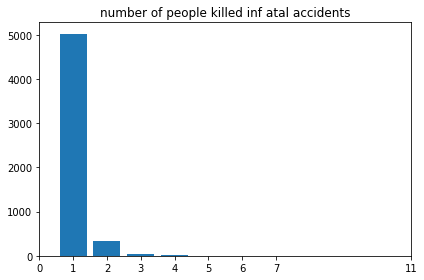

In [890]:
# how many people were killed in fatal accidents
fatal = accidents_orig[accidents_orig.severity == 1]
fatal_count = fatal.no_persons_killed.value_counts()

fig, ax = plt.subplots(figsize=(6,4))
ax.bar(fatal_count.index, fatal_count.values)

ax.set_xticks(fatal_count.index)
ax.set_xticklabels(fatal_count.index)
ax.set_xlim(0,11)
ax.set_title('number of people killed inf atal accidents')

plt.tight_layout()

In [891]:
fatal_count

1     5029
2      344
3       48
4       12
0        6
5        4
6        2
7        1
11       1
Name: no_persons_killed, dtype: int64

In [892]:
5029/5447*100

92.32605103726821

In [817]:
# plot number of fatal accidents

total = accidents_orig.groupby(['accidentyear'])['accident_no'].count()
fatalities = accidents_orig.groupby(['accidentyear'])['no_persons_killed'].sum()
fatal = accidents_orig.groupby(['accidentyear','fatality'])['accident_no'].count().reset_index()

fatal = fatal[fatal.fatality==1]
fatal['num_deaths'] = fatalities.values
fatal['total_accidents'] = total.values
fatal['fatal_percent'] = fatal.accident_no/fatal.total_accidents*100

fatal = fatal[fatal.accidentyear != 2020] # remove 2020 as it is incomplete
fatal.head()

,accidentyear,fatality,accident_no,num_deaths,total_accidents,fatal_percent
1,2000,1,373,407,17924,2.081009
3,2001,1,404,444,17381,2.324377
5,2002,1,361,397,17487,2.064391
7,2003,1,294,330,17005,1.728903
9,2004,1,312,343,16456,1.895965


In [818]:
print(accidents[accidents.accidentyear==2000].accidentdate.min())
print(accidents[accidents.accidentyear==2000].accidentdate.max())

2000-01-01 00:00:00
2000-12-31 00:00:00


In [819]:
print(accidents[accidents.accidentyear==2020].accidentdate.min())
print(accidents[accidents.accidentyear==2020].accidentdate.max())

2020-01-01 00:00:00
2020-11-01 00:00:00


In [822]:
fatal

,accidentyear,fatality,accident_no,num_deaths,total_accidents,fatal_percent
1,2000,1,373,407,17924,2.081009
3,2001,1,404,444,17381,2.324377
5,2002,1,361,397,17487,2.064391
7,2003,1,294,330,17005,1.728903
9,2004,1,312,343,16456,1.895965
11,2005,1,314,346,16808,1.868158
13,2006,1,309,337,13697,2.255968
15,2007,1,289,332,13854,2.086040
17,2008,1,278,303,14128,1.967724
19,2009,1,268,290,13851,1.934878


## Fatality variations with time

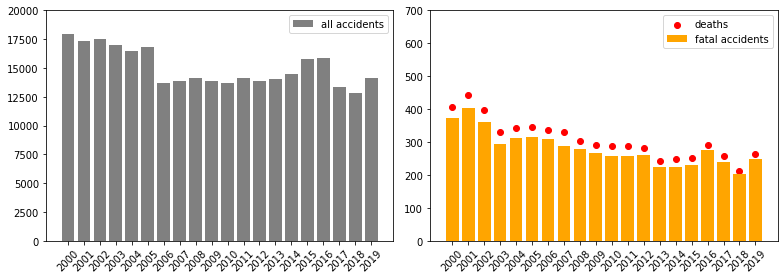

In [826]:
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize=(11,4))
ax1.bar(fatal.accidentyear, fatal.total_accidents, color = 'grey', label='all accidents')
ax1.set_ylim(0,20_000)
ax1.legend()

ax2.scatter(fatal.accidentyear, fatal.num_deaths, color = 'red', label='deaths')
ax2.bar(fatal.accidentyear, fatal.accident_no, color = 'orange', label='fatal accidents')
ax2.set_ylim(0,700)
ax2.legend(loc='upper right')

# ax3 = ax2.twinx()
# ax3.scatter(fatal.accidentyear, fatal.fatal_percent, color = 'red', label='% overall fatal')
# ax3.set_ylim(0,2.4)
# ax3.legend(loc='upper right')

for ax in [ax1, ax2]:
    ax.set_xticks(fatal.accidentyear.values)
    ax.set_xticklabels(fatal.accidentyear.values, rotation=45)

plt.tight_layout()

In [898]:
non_fatal_sorted.accidentmonth.astype(str)

22    12
0      1
2      2
4      3
6      4
8      5
10     6
12     7
14     8
16     9
18    10
20    11
Name: accidentmonth, dtype: object

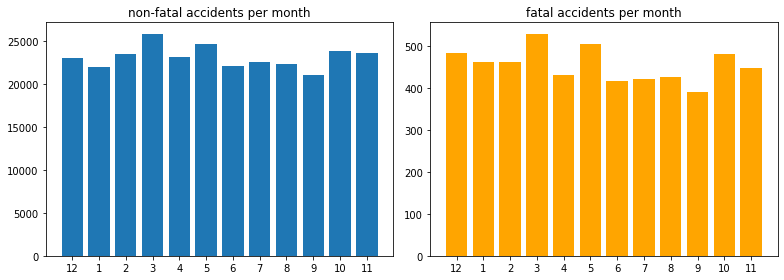

In [901]:
agg = accidents_orig.groupby(['accidentmonth','fatality'])['accident_no'].count().reset_index()

non_fatal = agg[agg.fatality==0].sort_values('accident_no',ascending=False)
fatal = agg[agg.fatality==1].sort_values('accident_no',ascending=False)

non_fatal_sorted = pd.DataFrame()
fatal_sorted = pd.DataFrame()
for day in [12,1,2,3,4,5,6,7,8,9,10,11]:
    non_fatal_sorted = non_fatal_sorted.append(non_fatal[non_fatal.accidentmonth==day])
    fatal_sorted = fatal_sorted.append(fatal[fatal.accidentmonth==day])
    
non_fatal_sorted.accidentmonth = non_fatal_sorted.accidentmonth.astype(str)
fatal_sorted.accidentmonth = fatal_sorted.accidentmonth.astype(str)

fig, ax = plt.subplots(ncols=2, figsize=(11,4))
ax[0].bar(non_fatal_sorted.accidentmonth, non_fatal_sorted.accident_no)
ax[1].bar(fatal_sorted.accidentmonth, fatal_sorted.accident_no, color='orange')

ax[0].set_title('non-fatal accidents per month')
ax[1].set_title('fatal accidents per month')

for ind in [0,1]:
    ax[ind].set_xticks(['12','1','2','3','4','5','6','7','8','9','10','11'])
    ax[ind].set_xticklabels(['12','1','2','3','4','5','6','7','8','9','10','11'])

plt.tight_layout()

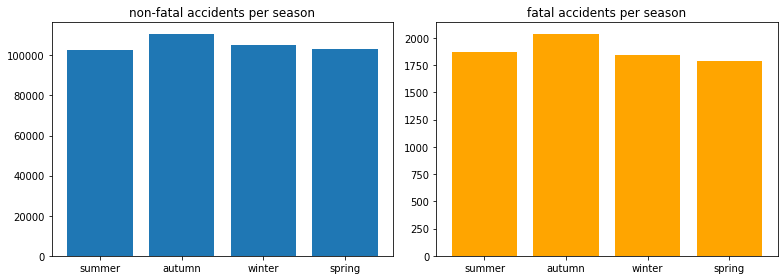

In [902]:
agg = accidents.groupby(['accidentseason','fatality'])['accident_no'].count().reset_index()

non_fatal = agg[agg.fatality==0].sort_values('accident_no',ascending=False)
non_fatal_sorted = pd.DataFrame()
for day in ['summer','autumn','winter','spring']:
    non_fatal_sorted = non_fatal_sorted.append(non_fatal[non_fatal.accidentseason==day])

fatal = agg[agg.fatality==1].sort_values('accident_no',ascending=False)
fatal_sorted = pd.DataFrame()
for day in ['summer','autumn','winter','spring']:
    fatal_sorted = fatal_sorted.append(fatal[fatal.accidentseason==day])
    
fig, ax = plt.subplots(ncols=2, figsize=(11,4))
ax[0].bar(non_fatal_sorted.accidentseason, non_fatal_sorted.accident_no)
ax[1].bar(fatal_sorted.accidentseason, fatal_sorted.accident_no, color='orange')

ax[0].set_title('non-fatal accidents per season')
ax[1].set_title('fatal accidents per season')

plt.tight_layout()

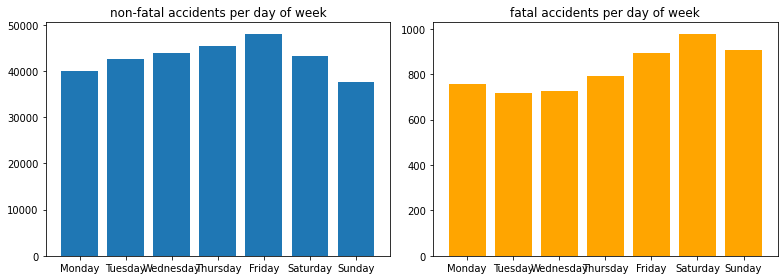

In [828]:
agg = accidents_orig.groupby(['day_week_description','fatality'])['accident_no'].count().reset_index()

non_fatal = agg[agg.fatality==0].sort_values('accident_no',ascending=False)
non_fatal_sorted = pd.DataFrame()
for day in ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']:
    non_fatal_sorted = non_fatal_sorted.append(non_fatal[non_fatal.day_week_description==day])

fatal = agg[agg.fatality==1].sort_values('accident_no',ascending=False)
fatal_sorted = pd.DataFrame()
for day in ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']:
    fatal_sorted = fatal_sorted.append(fatal[fatal.day_week_description==day])
    
fig, ax = plt.subplots(ncols=2, figsize=(11,4))
ax[0].bar(non_fatal_sorted.day_week_description, non_fatal_sorted.accident_no)
ax[1].bar(fatal_sorted.day_week_description, fatal_sorted.accident_no, color='orange')

ax[0].set_title('non-fatal accidents per day of week')
ax[1].set_title('fatal accidents per day of week')

plt.tight_layout()

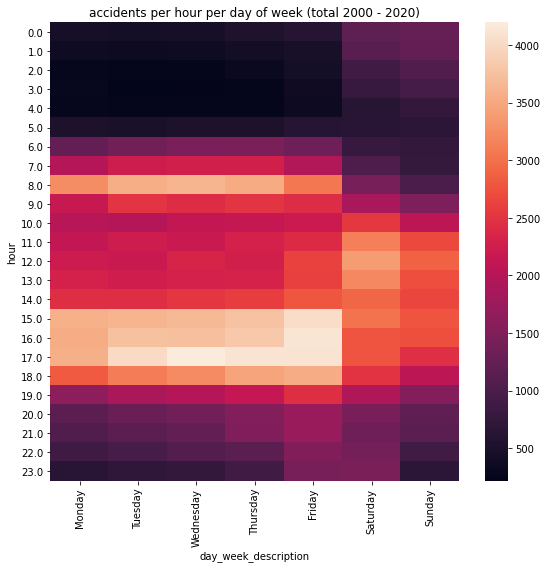

In [829]:
hourly_accidents = accidents_orig.groupby(['day_week_description','accidenthour'])['accident_no'].count()
hourly_accidents = hourly_accidents.reset_index()
hourly_accidents = pd.pivot_table(hourly_accidents, 
                                   values='accident_no',
                                   index='accidenthour',
                                   columns='day_week_description')
hourly_accidents = hourly_accidents[['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']]

plt.figure(figsize=(8,8))
sns.heatmap(hourly_accidents)
plt.ylabel('hour')
plt.title('accidents per hour per day of week (total 2000 - 2020)')
plt.tight_layout()

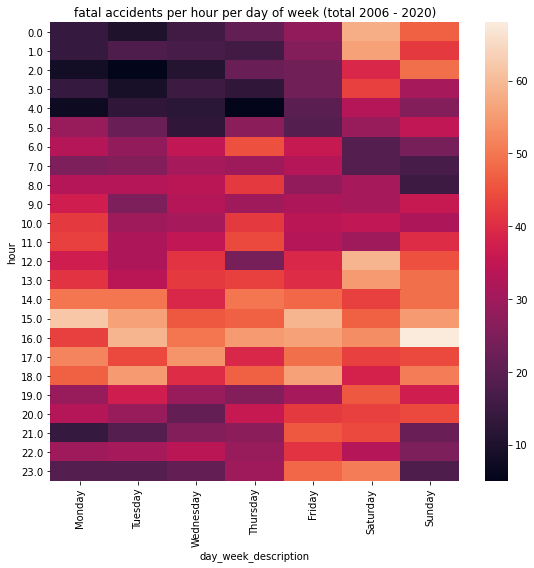

In [830]:
fatal_accidents = accidents_orig[accidents_orig.severity==1]

hourly_accidents = fatal_accidents.groupby(['day_week_description','accidenthour'])['accident_no'].count()
hourly_accidents = hourly_accidents.reset_index()
hourly_accidents = pd.pivot_table(hourly_accidents, 
                                   values='accident_no',
                                   index='accidenthour',
                                   columns='day_week_description')
hourly_accidents = hourly_accidents[['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']]

plt.figure(figsize=(8,8))
sns.heatmap(hourly_accidents)
plt.ylabel('hour')
plt.title('fatal accidents per hour per day of week (total 2006 - 2020)')
plt.tight_layout()

## Fatality variations with other factors

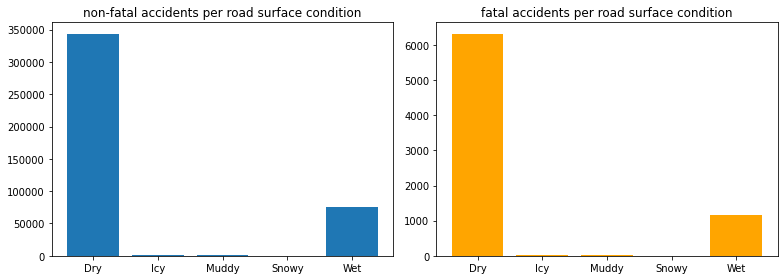

In [872]:
agg = accidents.groupby(['surface_cond_desc','fatality'])['accident_no'].count().reset_index()

fig, ax = plt.subplots(ncols=2, figsize=(11,4))
ax[0].bar(agg[agg.fatality==0].surface_cond_desc,agg[agg.fatality==0].accident_no)
ax[1].bar(agg[agg.fatality==1].surface_cond_desc,agg[agg.fatality==1].accident_no, color='orange')

ax[0].set_title('non-fatal accidents per road surface condition')
ax[1].set_title('fatal accidents per road surface condition')

plt.tight_layout()

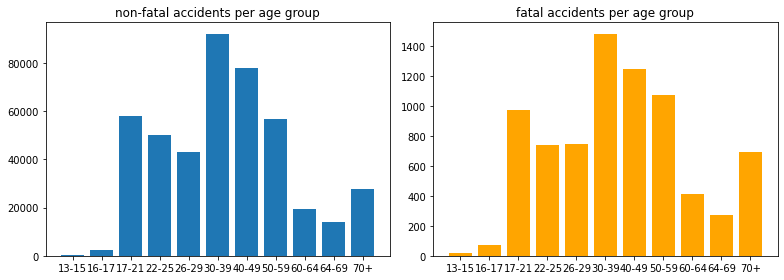

In [206]:
agg = accidents.groupby(['age_group','fatality'])['accident_no'].count().reset_index()

fig, ax = plt.subplots(ncols=2, figsize=(11,4))
ax[0].bar(agg[agg.fatality==0].age_group,agg[agg.fatality==0].accident_no)
ax[1].bar(agg[agg.fatality==1].age_group,agg[agg.fatality==1].accident_no, color='orange')

ax[0].set_title('non-fatal accidents per age group')
ax[1].set_title('fatal accidents per age group')

plt.tight_layout()

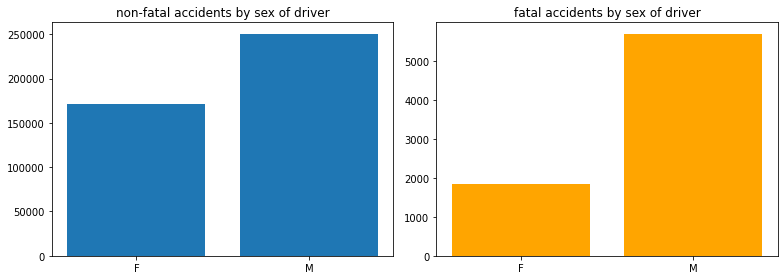

In [873]:
agg = accidents.groupby(['sex','fatality'])['accident_no'].count().reset_index()

fig, ax = plt.subplots(ncols=2, figsize=(11,4))
ax[0].bar(agg[agg.fatality==0].sex,agg[agg.fatality==0].accident_no)
ax[1].bar(agg[agg.fatality==1].sex,agg[agg.fatality==1].accident_no, color='orange')

ax[0].set_title('non-fatal accidents by sex of driver')
ax[1].set_title('fatal accidents by sex of driver')

plt.tight_layout()

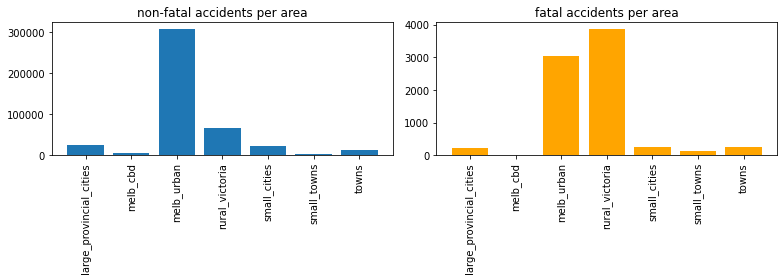

In [217]:
agg = accidents.groupby(['deg_urban_name','fatality'])['accident_no'].count().reset_index()

fig, ax = plt.subplots(ncols=2, figsize=(11,4))
ax[0].bar(agg[agg.fatality==0].deg_urban_name,agg[agg.fatality==0].accident_no)
ax[1].bar(agg[agg.fatality==1].deg_urban_name,agg[agg.fatality==1].accident_no, color='orange')

ax[0].set_title('non-fatal accidents per area')
ax[1].set_title('fatal accidents per area')

ax[0].set_xticklabels(agg.deg_urban_name.unique(), rotation=90)
ax[1].set_xticklabels(agg.deg_urban_name.unique(), rotation=90)

plt.tight_layout()

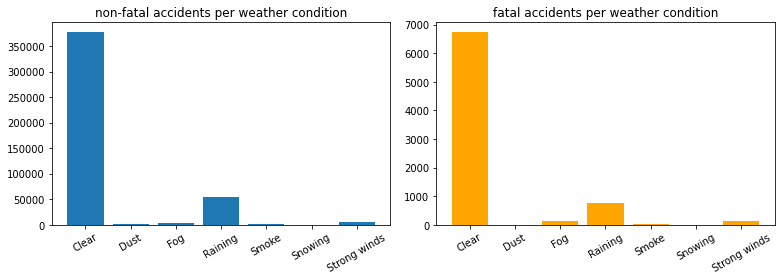

In [220]:
agg = accidents.groupby(['atmosph_cond_desc','fatality'])['accident_no'].count().reset_index()

fig, ax = plt.subplots(ncols=2, figsize=(11,4))
ax[0].bar(agg[agg.fatality==0].atmosph_cond_desc,agg[agg.fatality==0].accident_no)
ax[1].bar(agg[agg.fatality==1].atmosph_cond_desc,agg[agg.fatality==1].accident_no, color='orange')

ax[0].set_title('non-fatal accidents per weather condition')
ax[1].set_title('fatal accidents per weather condition')

ax[0].set_xticklabels(agg.atmosph_cond_desc.unique(), rotation=30)
ax[1].set_xticklabels(agg.atmosph_cond_desc.unique(), rotation=30)

plt.tight_layout()

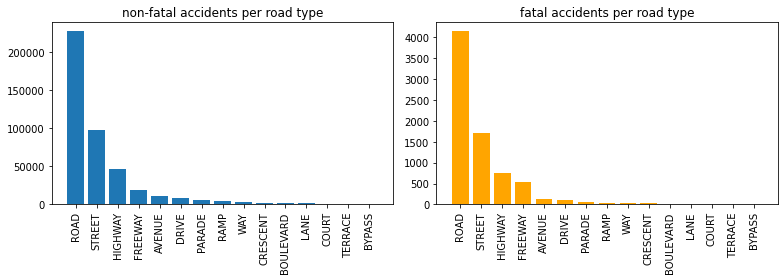

In [259]:
agg = accidents.groupby(['road_type','fatality'])['accident_no'].count().reset_index()

non_fatal = agg[agg.fatality==0].sort_values('accident_no',ascending=False)
fatal = agg[agg.fatality==1].sort_values('accident_no',ascending=False)

fig, ax = plt.subplots(ncols=2, figsize=(11,4))
ax[0].bar(non_fatal.road_type.head(15), non_fatal.accident_no.head(15))
ax[1].bar(fatal.road_type.head(15), fatal.accident_no.head(15), color='orange')

ax[0].set_title('non-fatal accidents per road type')
ax[1].set_title('fatal accidents per road type')

for ind in [0,1]:
    ax[ind].set_xticklabels(non_fatal.road_type.head(15).values, rotation=90)

plt.tight_layout()

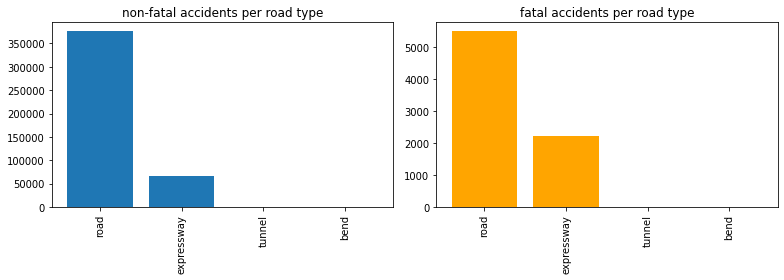

In [274]:
agg = accidents.groupby(['road_type','fatality'])['accident_no'].count().reset_index()

non_fatal = agg[agg.fatality==0].sort_values('accident_no',ascending=False)
fatal = agg[agg.fatality==1].sort_values('accident_no',ascending=False)

fig, ax = plt.subplots(ncols=2, figsize=(11,4))
ax[0].bar(non_fatal.road_type.head(15), non_fatal.accident_no.head(15))
ax[1].bar(fatal.road_type.head(15), fatal.accident_no.head(15), color='orange')

ax[0].set_title('non-fatal accidents per road type')
ax[1].set_title('fatal accidents per road type')

for ind in [0,1]:
    ax[ind].set_xticklabels(non_fatal.road_type.head(15).values, rotation=90)

plt.tight_layout()

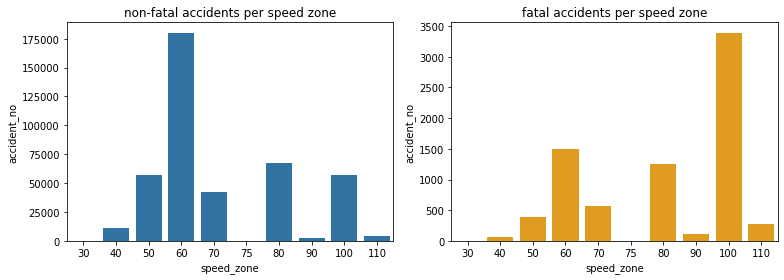

In [875]:
agg = accidents.groupby(['speed_zone','fatality'])['accident_no'].count().reset_index()

fig, ax = plt.subplots(ncols=2, figsize=(11,4))
sns.barplot(agg[agg.fatality==0].speed_zone,agg[agg.fatality==0].accident_no,ax=ax[0],color='#1f77b4')
sns.barplot(agg[agg.fatality==1].speed_zone,agg[agg.fatality==1].accident_no,ax=ax[1],color='orange')

ax[0].set_title('non-fatal accidents per speed zone')
ax[1].set_title('fatal accidents per speed zone')

for ind in [0,1]:
    ax[ind].set_xticklabels(agg.speed_zone.unique())

plt.tight_layout()

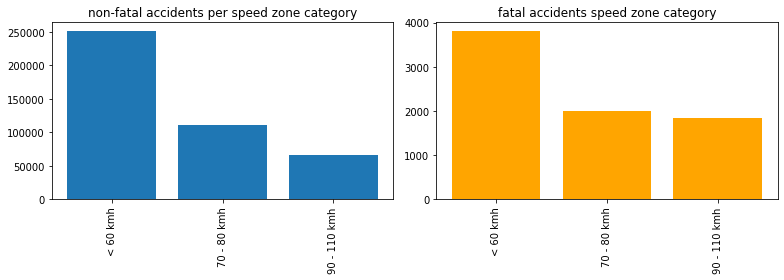

In [544]:
agg = accidents.groupby(['speed_zone_cat','fatality'])['accident_no'].count().reset_index()

non_fatal = agg[agg.fatality==0].sort_values('accident_no',ascending=False)
fatal = agg[agg.fatality==1].sort_values('accident_no',ascending=False)

fig, ax = plt.subplots(ncols=2, figsize=(11,4))
ax[0].bar(non_fatal.speed_zone_cat.head(15), non_fatal.accident_no.head(15))
ax[1].bar(fatal.speed_zone_cat.head(15), fatal.accident_no.head(15), color='orange')

ax[0].set_title('non-fatal accidents per speed zone category')
ax[1].set_title('fatal accidents speed zone category')

for ind in [0,1]:
    ax[ind].set_xticklabels(non_fatal.speed_zone_cat.head(15).values, rotation=90)

plt.tight_layout()

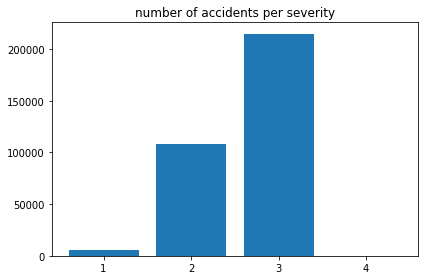

In [480]:
severity = accidents.severity.value_counts().sort_index()

plt.bar(severity.index, severity.values)
plt.title('number of accidents per severity')
plt.xticks(severity.index)
plt.tight_layout()

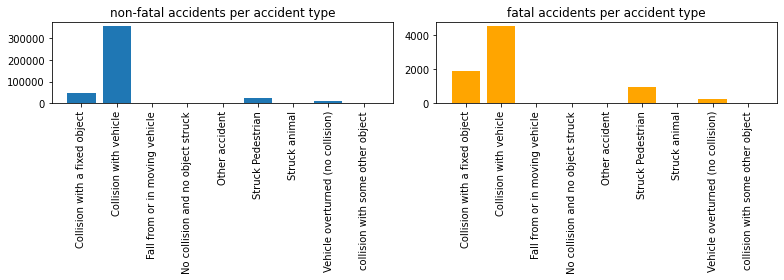

In [280]:
agg = accidents.groupby(['accident_type_desc','fatality'])['accident_no'].count().reset_index()

fig, ax = plt.subplots(ncols=2, figsize=(11,4))
ax[0].bar(agg[agg.fatality==0].accident_type_desc,agg[agg.fatality==0].accident_no)
ax[1].bar(agg[agg.fatality==1].accident_type_desc,agg[agg.fatality==1].accident_no, color='orange')

ax[0].set_title('non-fatal accidents per accident type')
ax[1].set_title('fatal accidents per accident type')

ax[0].set_xticklabels(agg.accident_type_desc.unique(), rotation=90)
ax[1].set_xticklabels(agg.accident_type_desc.unique(), rotation=90)

plt.tight_layout()

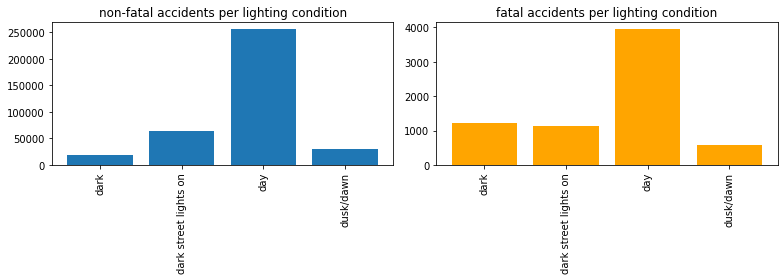

In [986]:
agg = accidents.groupby(['light_condition_desc','fatality'])['accident_no'].count().reset_index()

fig, ax = plt.subplots(ncols=2, figsize=(11,4))
ax[0].bar(agg[agg.fatality==0].light_condition_desc,agg[agg.fatality==0].accident_no)
ax[1].bar(agg[agg.fatality==1].light_condition_desc,agg[agg.fatality==1].accident_no, color='orange')

ax[0].set_title('non-fatal accidents per lighting condition')
ax[1].set_title('fatal accidents per lighting condition')

ax[0].set_xticklabels(agg.light_condition_desc.unique(), rotation=90)
ax[1].set_xticklabels(agg.light_condition_desc.unique(), rotation=90)

plt.tight_layout()

In [527]:
agg[agg.fatality==1]

,no_of_vehicles,fatality,accident_no
1,1,1,2725
3,2,1,3586
5,3,1,933
7,4,1,217
9,5,1,118
11,6,1,36
13,7,1,14
17,10,1,11
19,11,1,11


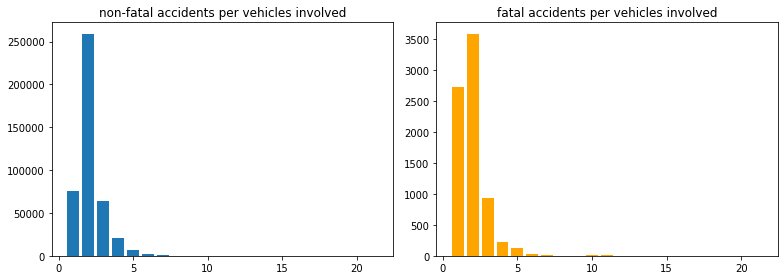

In [525]:
agg = accidents.groupby(['no_of_vehicles','fatality'])['accident_no'].count().reset_index()

fig, ax = plt.subplots(ncols=2, figsize=(11,4), sharex=True)
ax[0].bar(agg[agg.fatality==0].no_of_vehicles,agg[agg.fatality==0].accident_no)
ax[1].bar(agg[agg.fatality==1].no_of_vehicles,agg[agg.fatality==1].accident_no, color='orange')

ax[0].set_title('non-fatal accidents per vehicles involved')
ax[1].set_title('fatal accidents per vehicles involved')

# for ind in [0,1]:
#     ax[ind].set_xticklabels(agg[agg.fatality==0].no_of_vehicles.values)

plt.tight_layout()

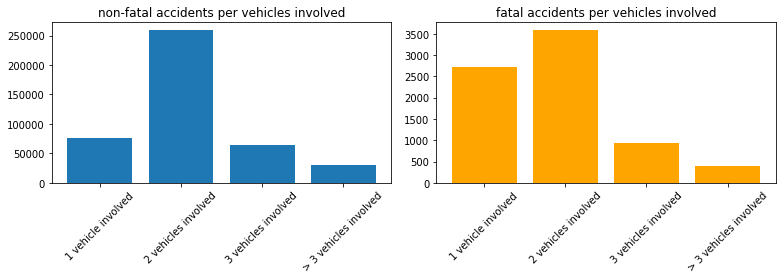

In [560]:
agg = accidents.groupby(['vehicles_cat','fatality'])['accident_no'].count().reset_index()

fig, ax = plt.subplots(ncols=2, figsize=(11,4), sharex=True)
ax[0].bar(agg[agg.fatality==0].vehicles_cat,agg[agg.fatality==0].accident_no)
ax[1].bar(agg[agg.fatality==1].vehicles_cat,agg[agg.fatality==1].accident_no, color='orange')

ax[0].set_title('non-fatal accidents per vehicles involved')
ax[1].set_title('fatal accidents per vehicles involved')

for ind in [0,1]:
    ax[ind].set_xticklabels(agg[agg.fatality==0].vehicles_cat.values, rotation=45)

plt.tight_layout()

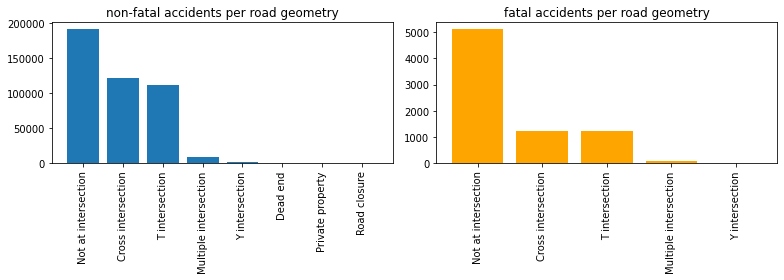

In [338]:
agg = accidents.groupby(['road_geometry_desc','fatality'])['accident_no'].count().reset_index()

non_fatal = agg[agg.fatality==0].sort_values('accident_no',ascending=False)
fatal = agg[agg.fatality==1].sort_values('accident_no',ascending=False)

fig, ax = plt.subplots(ncols=2, figsize=(11,4))
ax[0].bar(non_fatal.road_geometry_desc, non_fatal.accident_no)
ax[1].bar(fatal.road_geometry_desc, fatal.accident_no, color='orange')

ax[0].set_title('non-fatal accidents per road geometry')
ax[1].set_title('fatal accidents per road geometry')

for ind in [0,1]:
    ax[ind].set_xticklabels(non_fatal.road_geometry_desc.values, rotation=90)

plt.tight_layout()

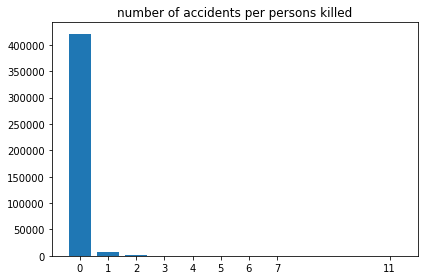

In [876]:
persons_killed = accidents.no_persons_killed.value_counts()

plt.bar(persons_killed.index, persons_killed.values)
plt.title('number of accidents per persons killed')
plt.xticks(persons_killed.index)
plt.tight_layout()

In [877]:
persons_killed

0     421727
1       6790
2        601
3         95
4         29
5          8
6          3
7          2
11         2
Name: no_persons_killed, dtype: int64

In [485]:
accidents[accidents.no_persons_killed==11].T

,21757
accident_no,T20070020494
accidentdate,2007-06-05 00:00:00
accidenttime,2022-01-10 13:39:00
accident_type,1
accident_type_desc,Collision with vehicle
day_of_week,3
day_week_description,Tuesday
dca_code,192
dca_description,STRUCK TRAIN
directory,VCS


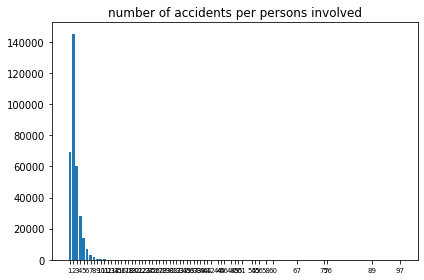

In [486]:
persons_involved = accidents.no_persons.value_counts()

plt.bar(persons_involved.index, persons_involved.values)
plt.title('number of accidents per persons involved')
plt.xticks(persons_involved.index, fontsize=7)
plt.tight_layout()

In [491]:
accidents.directory.value_counts()

MEL    248006
VCS     72148
         4901
VCD      2609
Name: directory, dtype: int64

In [492]:
accidents.edition.value_counts()

40      120655
40.0    106051
9        42015
9.0      32742
46       10678
43       10443
          4901
46.0       158
ED35        11
43.0        10
Name: edition, dtype: int64

In [493]:
accidents.page.value_counts().head(10)

29    5475
      4901
2B    4800
59    4710
30    4640
45    4395
80    4313
69    4107
96    3951
77    3852
Name: page, dtype: int64

In [502]:
# severity ranges from 1 (most severe, with deaths) to 2 3 and 4 (less severe, no deaths)
accidents.severity.value_counts()

3    215178
2    107928
1      6040
4       128
Name: severity, dtype: int64

In [503]:
accidents[accidents.severity == 1].no_persons_killed.value_counts()

1     5594
2      366
3       52
4       14
0        6
5        4
6        2
7        1
11       1
Name: no_persons_killed, dtype: int64

In [504]:
accidents[accidents.severity == 2].no_persons_killed.value_counts()

0    107928
Name: no_persons_killed, dtype: int64

In [505]:
accidents[accidents.severity == 3].no_persons_killed.value_counts()

0    215178
Name: no_persons_killed, dtype: int64

In [506]:
accidents[accidents.severity == 4].no_persons_killed.value_counts()

0    128
Name: no_persons_killed, dtype: int64

## Location of all accidents

In [1078]:
geometry = [Point(xy) for xy in zip(accidents_orig.long, accidents_orig.lat)]
geo_df = gpd.GeoDataFrame(accidents_orig, crs={'init': 'epsg:4326'}, geometry=geometry)
geo_df.to_crs({'init':'epsg:7844'}, inplace=True) 

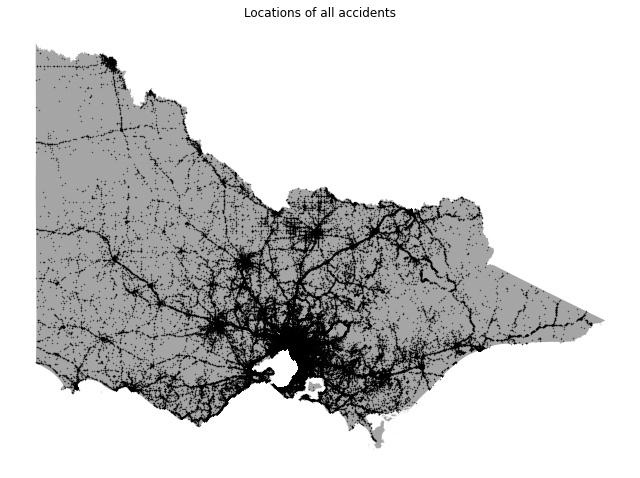

In [848]:
fig, ax = plt.subplots(figsize = (9,9))
vt_boundary.plot(color='grey', ax=ax, alpha = 0.7)

geo_df.plot(marker='.', 
            c = 'Black',
            alpha=.6, 
            markersize = 1,
            ax = ax)

plt.title('Locations of all accidents')
plt.axis('off')
plt.tight_layout()

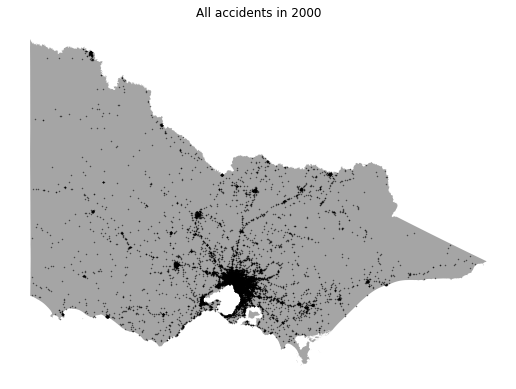

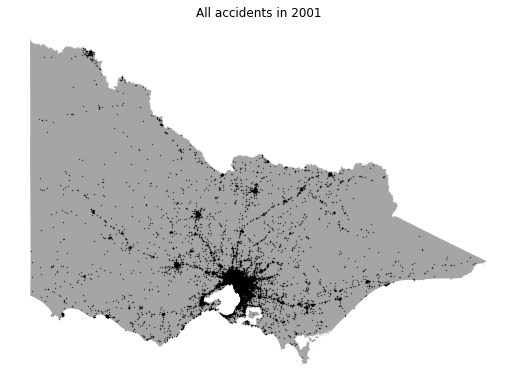

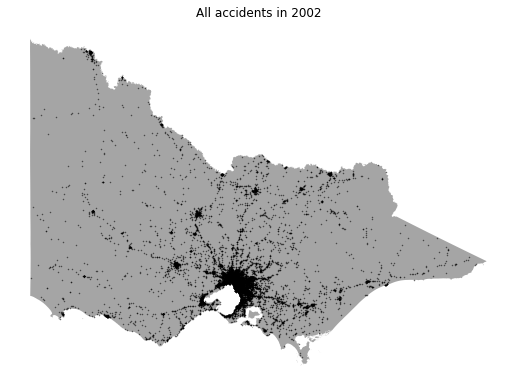

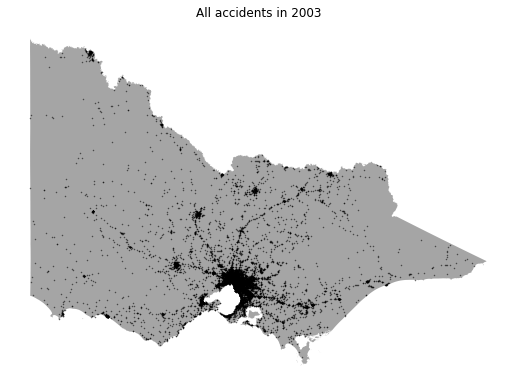

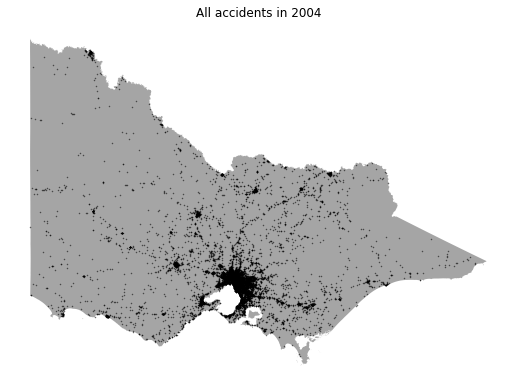

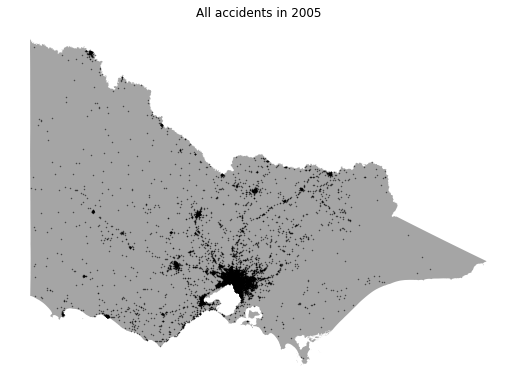

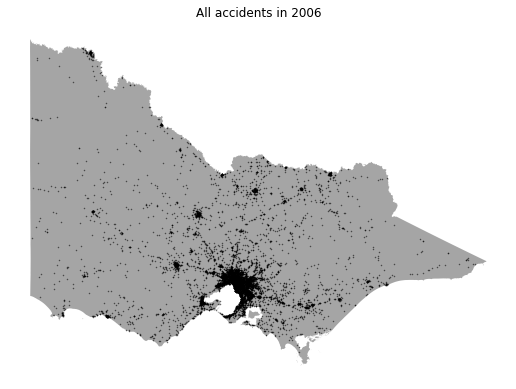

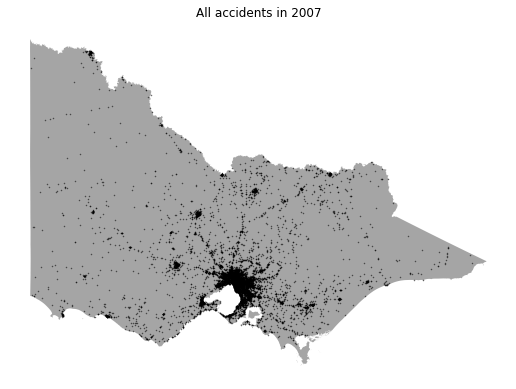

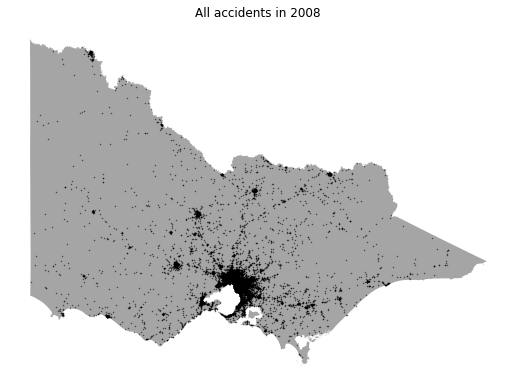

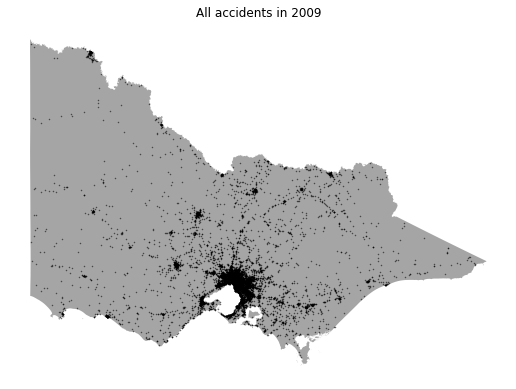

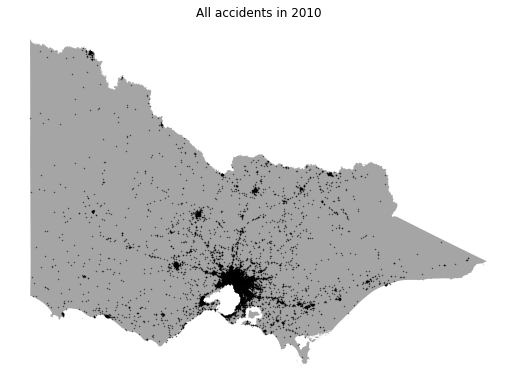

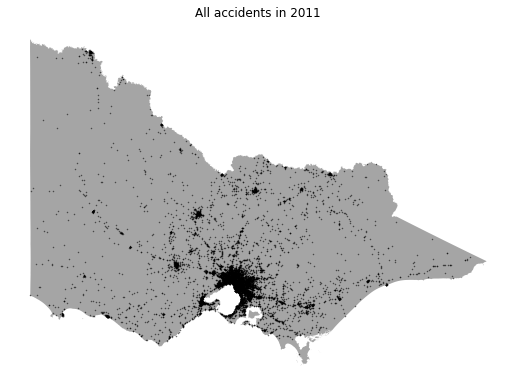

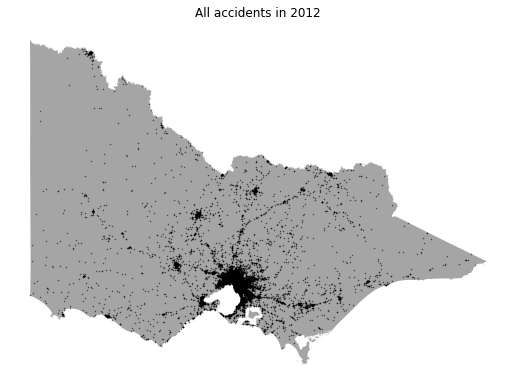

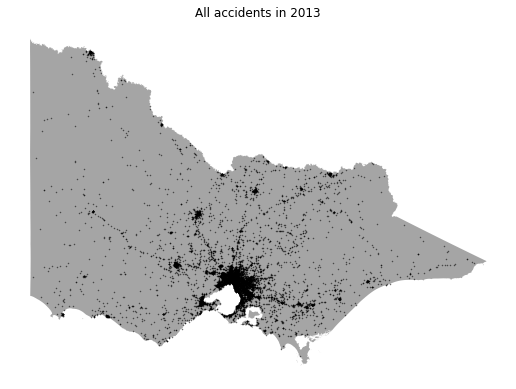

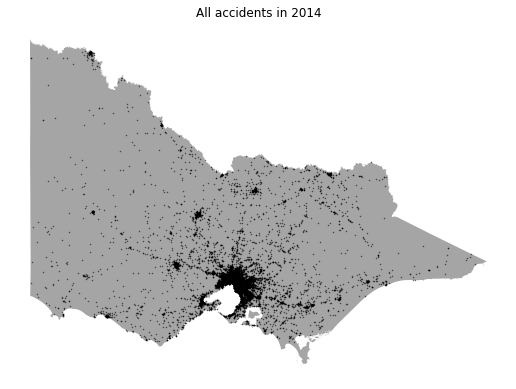

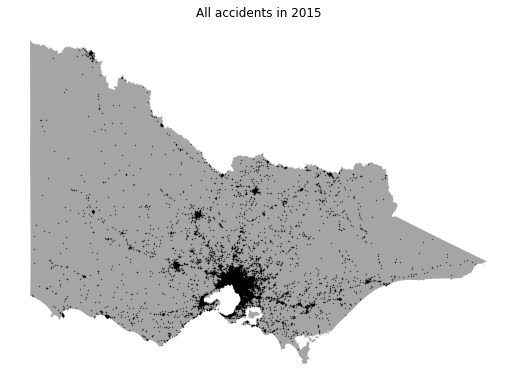

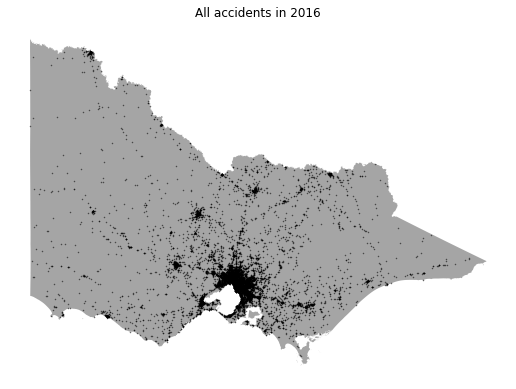

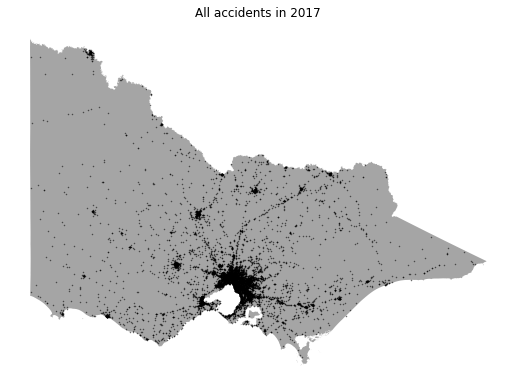

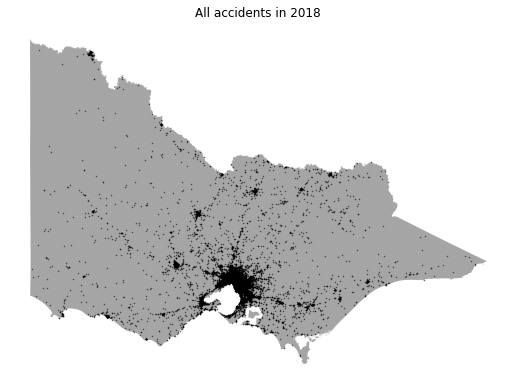

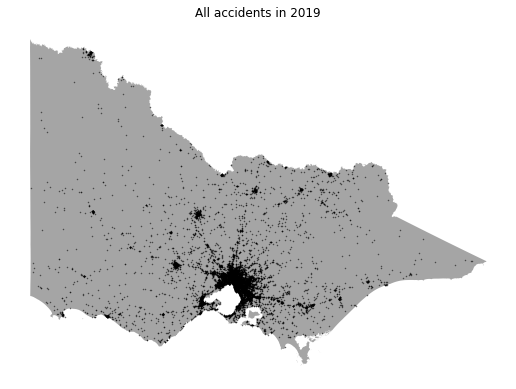

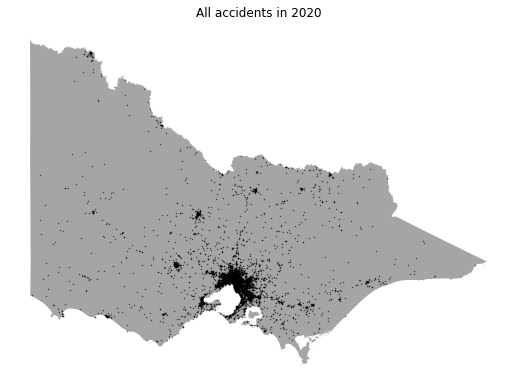

In [849]:
# save out plots for accident locations for each year
for year in geo_df.accidentyear.unique():

    fig, ax = plt.subplots(figsize = (9,9))
    vt_boundary.plot(color='grey', ax=ax, alpha = 0.7)

    geo_df[geo_df.accidentyear==year]\
        .plot(marker='.', 
              c = 'Black',
              alpha=.6, 
              markersize = 1,
              ax = ax)

    plt.title(f'All accidents in {year}')
    plt.axis('off')
    plt.savefig(f'{year}.png', bbox_inches='tight', dpi=200)

In [1080]:
geometry = [Point(xy) for xy in zip(accidents.long, accidents.lat)]
geo_df = gpd.GeoDataFrame(accidents, crs={'init': 'epsg:4326'}, geometry=geometry)
geo_df.to_crs({'init':'epsg:7844'}, inplace=True) 

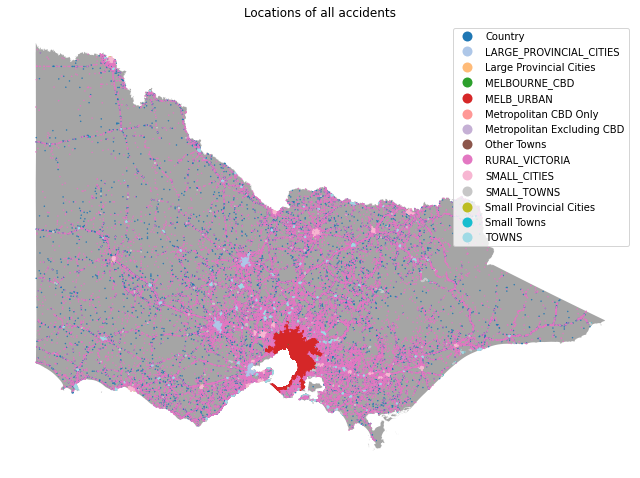

In [1079]:
# check what deg urban name means

fig, ax = plt.subplots(figsize = (9,9))
vt_boundary.plot(color='grey', ax=ax, alpha = 0.7)

geo_df.plot(marker='.',
            column='deg_urban_name',
            cmap='tab20',
            legend=True,
#             c = 'Black',
#             alpha=.6, 
            markersize = 1,
            ax = ax)

plt.title('Locations of all accidents')
plt.axis('off')
plt.tight_layout()

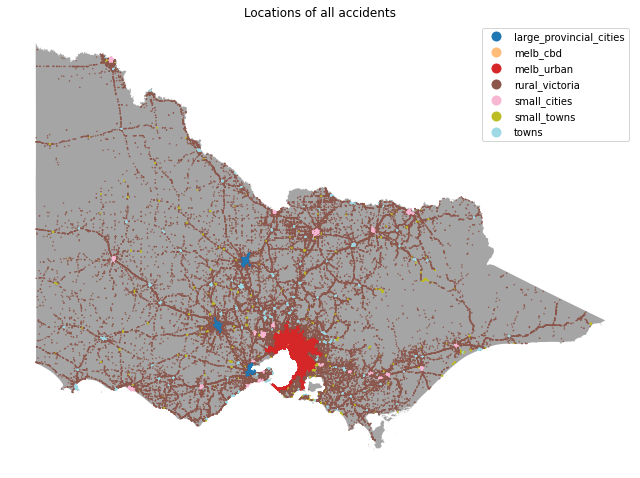

In [1081]:
# plot with corrected deg urban name

fig, ax = plt.subplots(figsize = (9,9))
vt_boundary.plot(color='grey', ax=ax, alpha = 0.7)

geo_df.plot(marker='.',
            column='deg_urban_name',
            cmap='tab20',
            legend=True,
#             c = 'Black',
#             alpha=.6, 
            markersize = 1,
            ax = ax)

plt.title('Locations of all accidents')
plt.axis('off')
plt.tight_layout()

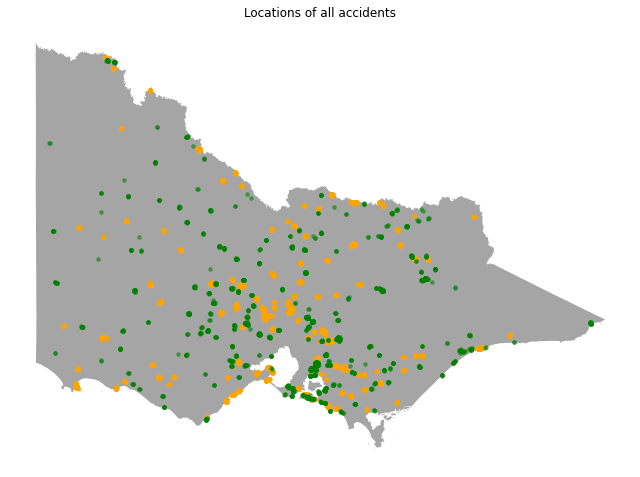

In [35]:
fig, ax = plt.subplots(figsize = (9,9))
vt_boundary.plot(color='grey', ax=ax, alpha = 0.7)

geo_df[geo_df.deg_urban_name=='TOWNS']\
.plot(marker='.', c = 'Orange', markersize = 50, alpha=0.5, ax = ax,legend=True)
geo_df[geo_df.deg_urban_name=='SMALL_TOWNS']\
.plot(marker='.', c = 'Green', markersize = 50, alpha=0.5, ax = ax, legend=True)

# geo_df[geo_df.deg_urban_name=='Metropolitan Excluding CBD']\
# .plot(marker='.', c = 'Black', markersize = 1, alpha=0.3, ax = ax, legend=True)
# geo_df[geo_df.deg_urban_name=='MELB_URBAN']\
# .plot(marker='.', c = 'Purple', markersize = 10, alpha=0.5, ax = ax, legend=True)

# geo_df[geo_df.deg_urban_name=='TOWNS']\
# .plot(marker='.', c = 'Red', markersize = 30, alpha=0.5, ax = ax, legend=True)
# geo_df[geo_df.deg_urban_name=='Other Towns']\
# .plot(marker='.', c = 'Blue', markersize = 30, alpha=0.5, ax = ax, legend=True)

plt.title('Locations of all accidents')
plt.axis('off')
plt.tight_layout()

In [36]:
name_mapper = {
    'MELBOURNE_CBD':'melb_cbd',
    'Metropolitan CBD Only':'melb_cbd', 
    
    'MELB_URBAN':'melb_urban', 
    'Metropolitan Excluding CBD':'melb_urban', 
    
    'RURAL_VICTORIA':'rural_victoria', 
    'Country':'rural_victoria',
    
    'LARGE_PROVINCIAL_CITIES':'large_provincial_cities', 
    'Large Provincial Cities':'large_provincial_cities', 

    'SMALL_CITIES':'small_cities', 
    'Small Provincial Cities':'small_cities', 

    'TOWNS':'towns',
    'Other Towns':'towns', 
    
    'SMALL_TOWNS':'small_towns', 
    'Small Towns':'small_towns'

}

accidents.deg_urban_name = accidents.deg_urban_name.replace(name_mapper)

In [37]:
accidents.deg_urban_name.value_counts().index

Index(['melb_urban', 'rural_victoria', 'large_provincial_cities',
       'small_cities', 'towns', 'melb_cbd', 'small_towns'],
      dtype='object')

## Location of fatal accidents

In [858]:
# locations of fatal accidents

# combine lat long into 1 location 
accidents_orig['location'] = accidents_orig.lat.round(4).astype(str) + ', ' + accidents_orig.long.round(4).astype(str)

# filter out accidents that are fatal
fatal_locations = accidents_orig[accidents_orig.severity == 1]

# count number of fatal accidents at each location
fatal_locations = fatal_locations.location.value_counts().sort_values(ascending=False)

fatal_locations = pd.DataFrame(fatal_locations)
fatal_locations['lat'] = [float(x.split(', ')[0]) for x in fatal_locations.index]
fatal_locations['long'] = [float(x.split(', ')[1]) for x in fatal_locations.index]

fatal_locations.head()

,location,lat,long
"-38.2571, 145.5504",4,-38.2571,145.5504
"-37.9799, 145.1427",3,-37.9799,145.1427
"-38.1548, 145.1645",3,-38.1548,145.1645
"-38.3395, 143.5924",3,-38.3395,143.5924
"-37.683, 144.7815",3,-37.6830,144.7815


In [851]:
fatal_locations.shape

(5368, 3)

In [852]:
# read in shapefile of boundaries
# soure: https://www.abs.gov.au/statistics/standards/australian-statistical-geography-standard-asgs-edition-3/jul2021-jun2026/access-and-downloads/digital-boundary-files

au_boundary = gpd.read_file("data/STE_2021_AUST_SHP_GDA2020/STE_2021_AUST_GDA2020.shp")
vt_boundary = au_boundary[au_boundary.STE_NAME21 == 'Victoria']

In [853]:
geometry = [Point(xy) for xy in zip(fatal_locations.long, fatal_locations.lat)]
geo_df = gpd.GeoDataFrame(fatal_locations, crs={'init': 'epsg:4326'}, geometry=geometry)
geo_df.to_crs({'init':'epsg:7844'}, inplace=True) 

In [861]:
geo_df.location.value_counts()

1    5295
2      68
3       4
4       1
Name: location, dtype: int64

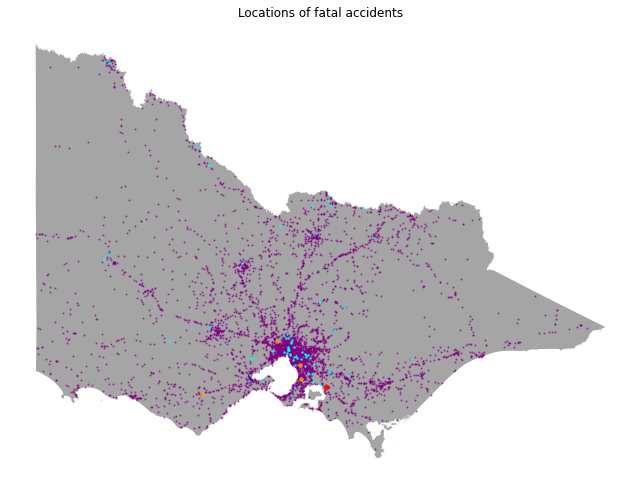

In [868]:
fig, ax = plt.subplots(figsize = (9,8))
vt_boundary.plot(color='grey', ax=ax, alpha = 0.7)

geo_df[geo_df.location==1].plot(marker='.', c = 'purple', alpha=.5, markersize = 5, ax = ax)
geo_df[geo_df.location==2].plot(marker='.', c = 'cyan', alpha=.8, markersize = 10, ax = ax)
geo_df[geo_df.location==3].plot(marker='.', c = 'orange', alpha=.8, markersize = 50, ax = ax)
geo_df[geo_df.location==4].plot(marker='.', c = 'red', alpha=.8, markersize = 100, ax = ax)

plt.title('Locations of fatal accidents')
plt.axis('off')
plt.tight_layout()

# Modelling

In [1033]:
# 2000 - 2005
accidents1 = pd.read_csv('data/2000 to 2005 ACCIDENT/ACCIDENT.csv',
                        parse_dates=[1,2],
                        infer_datetime_format=True, 
                        dayfirst=True)
accidents1['ACCIDENT_NO'] = [str(x) for x in accidents1.ACCIDENT_NO]
accidents1 = accidents1[(accidents1['Light Condition Desc'] != 'Unknown')&(accidents1['Light Condition Desc'] != 'Dark Street lights unknown')]
accidents1 = accidents1[accidents1['Road Geometry Desc'] != 'Unknown']
accidents1 = accidents1[accidents1['SPEED_ZONE']<777]

accident_loc1 = pd.read_csv('data/2000 to 2005 ACCIDENT/ACCIDENT_LOCATION.csv')[['ACCIDENT_NO','ROAD_TYPE']]
atmos_cond1 = pd.read_csv('data/2000 to 2005 ACCIDENT/ATMOSPHERIC_COND.csv')[['ACCIDENT_NO','Atmosph Cond Desc']]
atmos_cond1 = atmos_cond1[atmos_cond1['Atmosph Cond Desc'] != 'Not known']
node1 = pd.read_csv('data/2000 to 2005 ACCIDENT/NODE.csv')[['ACCIDENT_NO','Lat','Long','Deg Urban Name']]
road_cond1 = pd.read_csv('data/2000 to 2005 ACCIDENT/ROAD_SURFACE_COND.csv')[['ACCIDENT_NO','Surface Cond Desc']]
road_cond1 = road_cond1[road_cond1['Surface Cond Desc'] != 'Unknown']
person1 = pd.read_csv('data/2000 to 2005 ACCIDENT/PERSON.csv')
person1 = person1[person1['Road User Type Desc'] == 'Drivers'][['ACCIDENT_NO','SEX','Age Group']]
person1 = person1[(person1['Age Group']!='0-4')&(person1['Age Group']!='5-12')&(person1['Age Group']!='unknown')]
person1 = person1[person1['SEX']!='U']

# handle duplicates in each
atmos_cond1 = atmos_cond1.pivot_table(index='ACCIDENT_NO',columns='Atmosph Cond Desc',
                               aggfunc=len,fill_value=0)\
                          .reset_index()
road_cond1 = road_cond1.pivot_table(index='ACCIDENT_NO',columns='Surface Cond Desc',
                               aggfunc=len,fill_value=0)\
                       .reset_index()
node1 = node1.drop_duplicates('ACCIDENT_NO',keep=False)

# clean accident num column
for df in [accident_loc1, atmos_cond1, node1, road_cond1, person1]:
    df['ACCIDENT_NO'] = [str(x).strip() for x in df.ACCIDENT_NO]

for df in [accident_loc1,atmos_cond1,node1,road_cond1,person1]:
    accidents1 = pd.merge(left = accidents1,
                          right = df,
                          on='ACCIDENT_NO')
    
# 2006 - 2020
accidents2 = pd.read_csv('data/ACCIDENT/ACCIDENT.csv',
                        parse_dates=[1,2],
                        infer_datetime_format=True, 
                        dayfirst=True)
accidents2 = accidents2[(accidents2['Light Condition Desc'] != 'Unknown')&(accidents2['Light Condition Desc'] != 'Dark Street lights unknown')]
accidents2 = accidents2[accidents2['Road Geometry Desc'] != 'Unknown']
accidents2 = accidents2[accidents2['SPEED_ZONE']<777]

accident_loc2 = pd.read_csv('data/ACCIDENT/ACCIDENT_LOCATION.csv')[['ACCIDENT_NO','ROAD_TYPE']]
accident_loc2 = accident_loc2[accident_loc2.ROAD_TYPE != ' ']
atmos_cond2 = pd.read_csv('data/ACCIDENT/ATMOSPHERIC_COND.csv')[['ACCIDENT_NO','Atmosph Cond Desc']]
atmos_cond2 = atmos_cond2[atmos_cond2['Atmosph Cond Desc'] != 'Not known']
node2 = pd.read_csv('data/ACCIDENT/NODE.csv')[['ACCIDENT_NO','Lat','Long','DEG_URBAN_NAME']]
road_cond2 = pd.read_csv('data/ACCIDENT/ROAD_SURFACE_COND.csv')[['ACCIDENT_NO','Surface Cond Desc']]
road_cond2 = road_cond2[road_cond2['Surface Cond Desc'] != 'Unknown']
person2 = pd.read_csv('data/ACCIDENT/PERSON.csv')
person2 = person2[person2['Road User Type Desc'] == 'Drivers'][['ACCIDENT_NO','SEX','Age Group']]
person2 = person2[(person2['Age Group']!='0-4')&(person2['Age Group']!='5-12')&(person2['Age Group']!='unknown')]
person2 = person2[person2['SEX']!='U']

# handle duplicates in each
atmos_cond2 = atmos_cond2.pivot_table(index='ACCIDENT_NO',columns='Atmosph Cond Desc',
                               aggfunc=len,fill_value=0)\
                          .reset_index()
road_cond2 = road_cond2.pivot_table(index='ACCIDENT_NO',columns='Surface Cond Desc',
                               aggfunc=len,fill_value=0)\
                       .reset_index()
node2 = node2.drop_duplicates('ACCIDENT_NO',keep=False)

for df in [accident_loc2,atmos_cond2,node2,road_cond2,person2]:
    accidents2 = pd.merge(left = accidents2,
                          right = df,
                          on='ACCIDENT_NO')
    
# clean column names
for df in [accidents1, accidents2]:
    df.columns = [x.lower().replace(' ','_') for x in df.columns]
    
# clean up time column in 2000-2005 data
accidents1.accidenttime = accidents1.accidenttime.str.replace('.',':')
accidents1.accidenttime = pd.to_datetime(accidents1.accidenttime)

# merge both dataframes
accidents = pd.concat([accidents1, accidents2], axis=0)

# create new datetime columns
accidents['accidentmonth'] = accidents.accidentdate.dt.month
accidents['accidenthour'] = accidents.accidenttime.dt.hour

# create new boolean fatality column
accidents['fatality'] = accidents.severity.apply(lambda x: 0 if x != 1 else x)

# rename columns
accidents.deg_urban_name = accidents.deg_urban_name.replace(name_mapper)
accidents['accidentseason'] = accidents.accidentmonth.apply(season_mapper)
accidents['speed_zone_cat'] = accidents.speed_zone.apply(speed_mapper)
accidents['road_type_cat'] = accidents.road_type.apply(road_type_mapper)
accidents['vehicles_cat'] = accidents.no_of_vehicles.apply(vehicles_num_mapper)
accidents['light_condition_desc'] = accidents.light_condition_desc.apply(light_condition_mapper)
accidents['accidenttime_cat'] = [accident_day_mapper(h, d) for h,d in zip(accidents.accidenthour, accidents.day_week_description)]

accidents.dropna(inplace=True)

In [1034]:
accidents.shape

(369004, 54)

## Train-test-split

In [1044]:
y = accidents['fatality']
x = accidents[['accident_type_desc','light_condition_desc',
               'road_geometry_desc',
               'clear', 'dust', 'fog', 'raining', 'smoke','snowing', 'strong_winds',
               'dry','icy', 'muddy', 'snowy', 'wet', 
               'deg_urban_name','sex','age_group','speed_zone_cat','accidentseason','vehicles_cat',
               'accidenttime_cat']]

# split to get test set
xtrain, xtest, ytrain, ytest = train_test_split(x, 
                                                y, 
                                                stratify=y,
                                                random_state=1, 
                                                shuffle=True, 
                                                test_size=0.3)

# split again to get train and validation sets
xtrain, xval, ytrain, yval = train_test_split(xtrain, 
                                              ytrain, 
                                              stratify=ytrain,
                                              random_state=1, 
                                              shuffle=True, 
                                              test_size=0.3)

print(xtrain.shape)
print(ytrain.shape)
print()
print(xval.shape)
print(yval.shape)
print()
print(xtest.shape)
print(xtest.shape)

(180811, 22)
(180811,)

(77491, 22)
(77491,)

(110702, 22)
(110702, 22)


## Preprocessing

In [1045]:
# one hot encode categorical columns in x
obj_cols = ['accident_type_desc','light_condition_desc',
               'road_geometry_desc',
               'deg_urban_name','sex','age_group','speed_zone_cat','accidentseason','vehicles_cat',
           'accidenttime_cat']
# num_cols = ['accidenthour']
binary_cols = ['clear', 'dust', 'fog', 'raining', 'smoke','snowing', 'strong_winds',
               'dry','icy', 'muddy', 'snowy', 'wet', ]

def one_hot_transform(x_transformed_cat,original_x_df,col_names,binary_cols):
    """Joins one-hot transformed categorical columns with original numerical columns."""
    
    x_transformed_cat = pd.DataFrame(x_transformed_cat)
    x_transformed_cat.columns = col_names
    
#     x_transformed_num = pd.DataFrame(x_transformed_num)
#     x_transformed_num.columns = num_cols
#     x_transformed = pd.concat([x_transformed_cat, x_transformed_num], axis=1)

    x_transformed = pd.concat([x_transformed_cat, original_x_df[binary_cols].reset_index()], axis=1)
    x_transformed.index = original_x_df.index
    
    return x_transformed

In [1046]:
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
scaler = MinMaxScaler() 

# transform xtrain
xtrain_transformed_cat = encoder.fit_transform(xtrain[obj_cols])
# xtrain_transformed_num = scaler.fit_transform(xtrain[num_cols])

# get column names from encoder
col_names = []
for x in encoder.categories_:
    col_names.extend(x)

xtrain_transformed = one_hot_transform(xtrain_transformed_cat,xtrain,col_names,binary_cols)

# transform xval
xval_transformed_cat = encoder.transform(xval[obj_cols])
# xval_transformed_num = scaler.transform(xval[num_cols])
xval_transformed = one_hot_transform(xval_transformed_cat,xval,col_names,binary_cols)

# transform xtest
xtest_transformed_cat = encoder.transform(xtest[obj_cols])
# xtest_transformed_num = scaler.transform(xtest[num_cols])
xtest_transformed = one_hot_transform(xtest_transformed_cat,xtest,col_names,binary_cols)

print(xtrain_transformed.shape)
print(xval_transformed.shape)
print(xtest_transformed.shape)

(180811, 96)
(77491, 96)
(110702, 96)


In [1048]:
xtrain_transformed.columns[50:]

Index(['3 vehicles involved', '> 3 vehicles involved', 'Friday_day_offpeak',
       'Friday_evening_peak', 'Friday_morning_peak',
       'Friday_night_postmidnight', 'Friday_night_premidnight',
       'Monday_day_offpeak', 'Monday_evening_peak', 'Monday_morning_peak',
       'Monday_night_postmidnight', 'Monday_night_premidnight', 'Saturday_day',
       'Saturday_night_postmidnight', 'Saturday_night_premidnight',
       'Sunday_day', 'Sunday_night_postmidnight', 'Sunday_night_premidnight',
       'Thursday_day_offpeak', 'Thursday_evening_peak',
       'Thursday_morning_peak', 'Thursday_night_postmidnight',
       'Thursday_night_premidnight', 'Tuesday_day_offpeak',
       'Tuesday_evening_peak', 'Tuesday_morning_peak',
       'Tuesday_night_postmidnight', 'Tuesday_night_premidnight',
       'Wednesday_day_offpeak', 'Wednesday_evening_peak',
       'Wednesday_morning_peak', 'Wednesday_night_postmidnight',
       'Wednesday_night_premidnight', 'index', 'clear', 'dust', 'fog',
       'rai

In [1049]:
# set class weights of unbalanced classes
class_weights = {0: y[y==1].shape[0]/y.shape[0],
                 1: 1 - (y[y==1].shape[0]/y.shape[0])}

## Baseline model

In [994]:
dummy = DummyClassifier()
dummy.fit(xtrain_transformed, ytrain)

ypred_train = dummy.predict(xtrain_transformed)
ypred_val = dummy.predict(xval_transformed)

print('training scores')
print(classification_report(ytrain, ypred_train))

training scores
              precision    recall  f1-score   support

           0       0.98      0.98      0.98    177490
           1       0.02      0.02      0.02      3321

    accuracy                           0.96    180811
   macro avg       0.50      0.50      0.50    180811
weighted avg       0.96      0.96      0.96    180811



In [995]:
print('validation scores')
print(classification_report(yval, ypred_val))

validation scores
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     76067
           1       0.02      0.03      0.03      1424

    accuracy                           0.96     77491
   macro avg       0.50      0.50      0.50     77491
weighted avg       0.96      0.96      0.96     77491



## Logistic regression

In [70]:
lr = LogisticRegression(solver='liblinear',class_weight=class_weights)
lr.fit(xtrain_transformed, ytrain)

ypred_train = lr.predict(xtrain_transformed)
ypred_val = lr.predict(xval_transformed)

print('training scores')
print(classification_report(ytrain, ypred_train))

training scores
              precision    recall  f1-score   support

           0       0.99      0.73      0.84    155437
           1       0.04      0.65      0.08      2905

    accuracy                           0.73    158342
   macro avg       0.52      0.69      0.46    158342
weighted avg       0.97      0.73      0.83    158342



In [71]:
print('validation scores')
print(classification_report(yval, ypred_val))

validation scores
              precision    recall  f1-score   support

           0       0.99      0.73      0.84     66616
           1       0.04      0.66      0.08      1245

    accuracy                           0.73     67861
   macro avg       0.52      0.69      0.46     67861
weighted avg       0.97      0.73      0.83     67861



In [94]:
# try gridsearching class weights

lr = LogisticRegression(solver='liblinear')

weights = np.arange(0, 1, 0.001)
params = {
    'class_weight': [{0:x, 1:1-x} for x in weights]
}

gs = GridSearchCV(lr, params, scoring='recall_macro', n_jobs=8, cv=3)
gs.fit(xtrain_transformed, ytrain)
print(gs.best_params_)

ypred_train = gs.predict(xtrain_transformed)
ypred_val = gs.predict(xval_transformed)

print('training scores')
print(classification_report(ytrain, ypred_train))

{'class_weight': {0: 0.018000000000000002, 1: 0.982}}
training scores
              precision    recall  f1-score   support

           0       0.99      0.73      0.84    155437
           1       0.04      0.66      0.08      2905

    accuracy                           0.72    158342
   macro avg       0.52      0.69      0.46    158342
weighted avg       0.97      0.72      0.82    158342



In [96]:
print('validation scores')
print(classification_report(yval, ypred_val))

validation scores
              precision    recall  f1-score   support

           0       0.99      0.73      0.84     66616
           1       0.04      0.66      0.08      1245

    accuracy                           0.73     67861
   macro avg       0.52      0.70      0.46     67861
weighted avg       0.97      0.73      0.83     67861



In [392]:
# add new features/cleaned columns

lr = LogisticRegression(solver='liblinear',class_weight=class_weights)
lr.fit(xtrain_transformed, ytrain)

ypred_train = lr.predict(xtrain_transformed)
ypred_val = lr.predict(xval_transformed)

print('training scores')
print(classification_report(ytrain, ypred_train))

training scores
              precision    recall  f1-score   support

           0       0.99      0.76      0.86    213097
           1       0.05      0.70      0.09      3751

    accuracy                           0.76    216848
   macro avg       0.52      0.73      0.48    216848
weighted avg       0.98      0.76      0.85    216848



In [393]:
print('validation scores')
print(classification_report(yval, ypred_val))

validation scores
              precision    recall  f1-score   support

           0       0.99      0.76      0.86     91329
           1       0.05      0.69      0.09      1607

    accuracy                           0.76     92936
   macro avg       0.52      0.72      0.48     92936
weighted avg       0.98      0.76      0.85     92936



In [398]:
# removed surface_cond_desc, road_type from features

lr = LogisticRegression(solver='liblinear',class_weight=class_weights)
lr.fit(xtrain_transformed, ytrain)

ypred_train = lr.predict(xtrain_transformed)
ypred_val = lr.predict(xval_transformed)

print('training scores')
print(classification_report(ytrain, ypred_train))

training scores
              precision    recall  f1-score   support

           0       0.99      0.76      0.86    213097
           1       0.05      0.70      0.09      3751

    accuracy                           0.76    216848
   macro avg       0.52      0.73      0.48    216848
weighted avg       0.98      0.76      0.85    216848



In [399]:
print('validation scores')
print(classification_report(yval, ypred_val))

validation scores
              precision    recall  f1-score   support

           0       0.99      0.76      0.86     91329
           1       0.05      0.69      0.09      1607

    accuracy                           0.76     92936
   macro avg       0.52      0.73      0.48     92936
weighted avg       0.98      0.76      0.85     92936



In [487]:
# add season; changed speed to categorical; scaled num features to (0,1)

lr = LogisticRegression(solver='liblinear',class_weight=class_weights)
lr.fit(xtrain_transformed, ytrain)

ypred_train = lr.predict(xtrain_transformed)
ypred_val = lr.predict(xval_transformed)

print('training scores')
print(classification_report(ytrain, ypred_train))

training scores
              precision    recall  f1-score   support

           0       0.99      0.75      0.86    213097
           1       0.05      0.73      0.09      3751

    accuracy                           0.75    216848
   macro avg       0.52      0.74      0.47    216848
weighted avg       0.98      0.75      0.84    216848



In [488]:
print('validation scores')
print(classification_report(yval, ypred_val))

validation scores
              precision    recall  f1-score   support

           0       0.99      0.75      0.86     91329
           1       0.05      0.71      0.09      1607

    accuracy                           0.75     92936
   macro avg       0.52      0.73      0.47     92936
weighted avg       0.98      0.75      0.84     92936



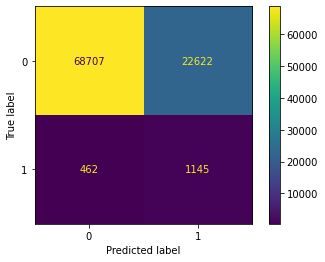

In [489]:
ConfusionMatrixDisplay(confusion_matrix(yval, ypred_val)).plot()

In [567]:
# combined speed categories, combined vehicles involved categories

lr = LogisticRegression(solver='liblinear',class_weight=class_weights)
lr.fit(xtrain_transformed, ytrain)

ypred_train = lr.predict(xtrain_transformed)
ypred_val = lr.predict(xval_transformed)

print('training scores')
print(classification_report(ytrain, ypred_train))

training scores
              precision    recall  f1-score   support

           0       0.99      0.76      0.86    206643
           1       0.05      0.72      0.09      3692

    accuracy                           0.75    210335
   macro avg       0.52      0.74      0.48    210335
weighted avg       0.98      0.75      0.84    210335



In [568]:
print('validation scores')
print(classification_report(yval, ypred_val))

validation scores
              precision    recall  f1-score   support

           0       0.99      0.75      0.86     88561
           1       0.05      0.72      0.09      1583

    accuracy                           0.75     90144
   macro avg       0.52      0.74      0.48     90144
weighted avg       0.98      0.75      0.84     90144



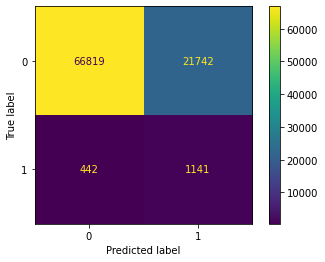

In [569]:
ConfusionMatrixDisplay(confusion_matrix(yval, ypred_val)).plot()

In [576]:
# try feature selection

lr = LogisticRegression(solver='liblinear',class_weight=class_weights)

pipeline = Pipeline([
#     ('feature_selection', PCA()),
    ('feature_selection', SelectKBest()),
    ('classifier', lr)
])

params = {
#     'feature_selection__n_components': [1,3,5]
    'feature_selection__k': [5,10,20,50,60,65,xtrain_transformed.shape[1]]

}

gs = GridSearchCV(pipeline, params, scoring='recall_macro', n_jobs=8, cv=3)
gs.fit(xtrain_transformed, ytrain)
print(gs.best_params_)

ypred_train = gs.predict(xtrain_transformed)
ypred_val = gs.predict(xval_transformed)

print('training scores')
print(classification_report(ytrain, ypred_train))

{'feature_selection__k': 65}
training scores
              precision    recall  f1-score   support

           0       0.99      0.75      0.86    206643
           1       0.05      0.72      0.09      3692

    accuracy                           0.75    210335
   macro avg       0.52      0.74      0.48    210335
weighted avg       0.98      0.75      0.84    210335



In [574]:
print('validation scores')
print(classification_report(yval, ypred_val))

validation scores
              precision    recall  f1-score   support

           0       0.99      0.75      0.86     88561
           1       0.05      0.72      0.09      1583

    accuracy                           0.75     90144
   macro avg       0.52      0.74      0.48     90144
weighted avg       0.98      0.75      0.84     90144



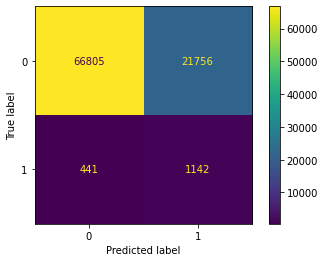

In [578]:
ConfusionMatrixDisplay(confusion_matrix(yval, ypred_val)).plot()

In [996]:
# updated weather cols to reflect accidents with multiple conditions (eg wind+rain)
# combined dark conditions

lr = LogisticRegression(solver='liblinear',class_weight=class_weights)
lr.fit(xtrain_transformed, ytrain)

ypred_train = lr.predict(xtrain_transformed)
ypred_val = lr.predict(xval_transformed)

print('training scores')
print(classification_report(ytrain, ypred_train))

training scores
              precision    recall  f1-score   support

           0       0.99      0.76      0.86    177490
           1       0.05      0.71      0.10      3321

    accuracy                           0.76    180811
   macro avg       0.52      0.74      0.48    180811
weighted avg       0.98      0.76      0.85    180811



In [997]:
print('validation scores')
print(classification_report(yval, ypred_val))

validation scores
              precision    recall  f1-score   support

           0       0.99      0.76      0.86     76067
           1       0.05      0.72      0.10      1424

    accuracy                           0.76     77491
   macro avg       0.52      0.74      0.48     77491
weighted avg       0.98      0.76      0.85     77491



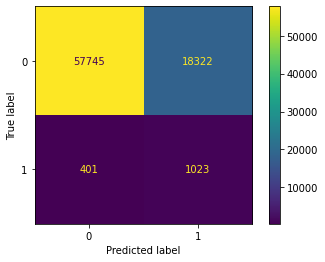

In [998]:
ConfusionMatrixDisplay(confusion_matrix(yval, ypred_val)).plot()

In [1050]:
# combined dayofweek and hrs into 1 categorical column

lr = LogisticRegression(solver='liblinear',class_weight=class_weights)
lr.fit(xtrain_transformed, ytrain)

ypred_train = lr.predict(xtrain_transformed)
ypred_val = lr.predict(xval_transformed)

print('training scores')
print(classification_report(ytrain, ypred_train))

training scores
              precision    recall  f1-score   support

           0       0.99      0.76      0.86    177490
           1       0.05      0.71      0.10      3321

    accuracy                           0.76    180811
   macro avg       0.52      0.74      0.48    180811
weighted avg       0.98      0.76      0.85    180811



In [1051]:
print('validation scores')
print(classification_report(yval, ypred_val))

validation scores
              precision    recall  f1-score   support

           0       0.99      0.76      0.86     76067
           1       0.05      0.72      0.10      1424

    accuracy                           0.76     77491
   macro avg       0.52      0.74      0.48     77491
weighted avg       0.98      0.76      0.85     77491



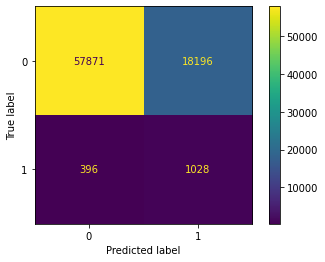

In [1052]:
ConfusionMatrixDisplay(confusion_matrix(yval, ypred_val)).plot()

In [1065]:
# try feature selection

lr = LogisticRegression(solver='liblinear',class_weight=class_weights)

pipeline = Pipeline([
#     ('feature_selection', PCA()),
    ('feature_selection', SelectKBest()),
    ('classifier', lr)
])

params = {
#     'feature_selection__n_components': [1,3,5]
    'feature_selection__k': [5, 20, 60, 80,xtrain_transformed.shape[1]]

}

gs = GridSearchCV(pipeline, params, scoring='recall_macro', n_jobs=8, cv=3)
gs.fit(xtrain_transformed, ytrain)
print(gs.best_params_)

ypred_train = gs.predict(xtrain_transformed)
ypred_val = gs.predict(xval_transformed)

print('training scores')
print(classification_report(ytrain, ypred_train))

{'feature_selection__k': 60}
training scores
              precision    recall  f1-score   support

           0       0.99      0.76      0.86    177490
           1       0.05      0.71      0.10      3321

    accuracy                           0.76    180811
   macro avg       0.52      0.74      0.48    180811
weighted avg       0.98      0.76      0.85    180811



In [1066]:
print('validation scores')
print(classification_report(yval, ypred_val))

validation scores
              precision    recall  f1-score   support

           0       0.99      0.76      0.86     76067
           1       0.05      0.73      0.10      1424

    accuracy                           0.76     77491
   macro avg       0.52      0.74      0.48     77491
weighted avg       0.98      0.76      0.85     77491



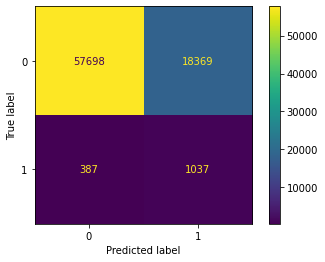

In [1067]:
ConfusionMatrixDisplay(confusion_matrix(yval, ypred_val)).plot()

In [1068]:
ypred_test = gs.predict(xtest_transformed)

print('test scores')
print(classification_report(ytest, ypred_test))

test scores
              precision    recall  f1-score   support

           0       0.99      0.76      0.86    108669
           1       0.05      0.73      0.10      2033

    accuracy                           0.76    110702
   macro avg       0.52      0.74      0.48    110702
weighted avg       0.98      0.76      0.85    110702



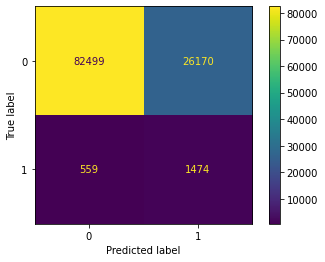

In [1069]:
ConfusionMatrixDisplay(confusion_matrix(ytest, ypred_test)).plot()

In [1056]:
# check misclassifications
results = xval.copy()
results['actual'] = yval
results['pred'] = ypred_val

results = results[results.actual!=results.pred]
results[results.actual==1]

,accident_type_desc,light_condition_desc,road_geometry_desc,clear,dust,fog,raining,smoke,snowing,strong_winds,...,wet,deg_urban_name,sex,age_group,speed_zone_cat,accidentseason,vehicles_cat,accidenttime_cat,actual,pred
131077,Collision with vehicle,day,Cross intersection,1,0,0,0,0,0,0,...,0,small_cities,M,40-49,70 - 80 kmh,spring,2 vehicles involved,Thursday_day_offpeak,1,0
51577,Vehicle overturned (no collision),day,Not at intersection,1,0,0,0,0,0,0,...,0,small_cities,M,40-49,90 - 110 kmh,autumn,1 vehicle involved,Thursday_night_premidnight,1,0
130805,Collision with a fixed object,dark street lights on,Cross intersection,1,0,0,0,0,0,0,...,1,melb_urban,M,22-25,70 - 80 kmh,spring,1 vehicle involved,Friday_night_premidnight,1,0
187408,Collision with vehicle,day,Not at intersection,1,0,0,0,0,0,0,...,0,melb_urban,M,64-69,70 - 80 kmh,winter,> 3 vehicles involved,Sunday_day,1,0
102006,Collision with vehicle,dark street lights on,Not at intersection,1,0,0,0,0,0,0,...,0,melb_urban,M,50-59,< 60 kmh,autumn,2 vehicles involved,Sunday_night_postmidnight,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84077,Collision with vehicle,dark street lights on,T intersection,1,0,0,0,0,0,0,...,0,melb_urban,F,40-49,< 60 kmh,autumn,2 vehicles involved,Thursday_night_postmidnight,1,0
14626,Collision with vehicle,dark street lights on,Cross intersection,1,0,0,0,0,0,0,...,0,melb_urban,M,26-29,< 60 kmh,spring,2 vehicles involved,Sunday_night_postmidnight,1,0
34180,Collision with vehicle,dusk/dawn,Not at intersection,1,0,0,0,0,0,0,...,0,melb_urban,F,30-39,< 60 kmh,autumn,2 vehicles involved,Sunday_night_postmidnight,1,0
29972,Collision with vehicle,dusk/dawn,Not at intersection,0,0,0,1,0,0,0,...,1,melb_urban,M,22-25,90 - 110 kmh,winter,2 vehicles involved,Thursday_night_premidnight,1,0


In [1057]:
selected_cols = gs.best_estimator_.named_steps["feature_selection"].get_support()

coef = pd.DataFrame(gs.best_estimator_.named_steps["classifier"].coef_, 
                    columns=xtrain_transformed.columns[selected_cols], 
                    index=['coef']).T

coef.sort_values('coef',ascending=False).head(10)

,coef
Struck Pedestrian,2.591391
Fall from or in moving vehicle,1.477487
Collision with a fixed object,1.386461
13-15,0.702634
rural_victoria,0.632764
Saturday_night_postmidnight,0.625346
Friday_night_postmidnight,0.603919
Thursday_night_postmidnight,0.594732
small_towns,0.554999
70+,0.489648


In [1058]:
coef.sort_values('coef',ascending=False).tail(10)

,coef
Wednesday_morning_peak,-0.325724
Thursday_evening_peak,-0.356609
Tuesday_morning_peak,-0.374960
small_cities,-0.475333
melb_urban,-0.576821
large_provincial_cities,-0.658198
F,-0.663729
1 vehicle involved,-0.791818
< 60 kmh,-0.816030
melb_cbd,-2.124531


<BarContainer object of 20 artists>

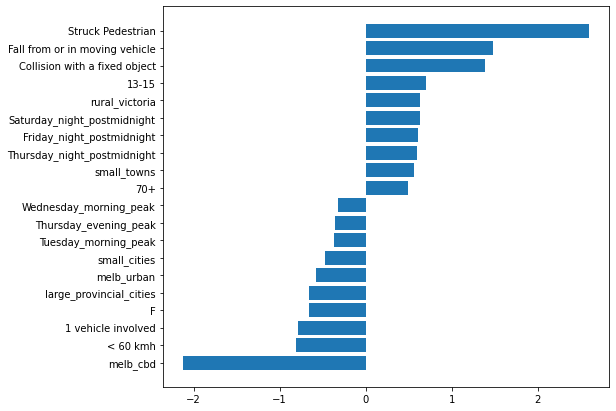

In [1059]:
plt.figure(figsize=(8,7))
top_coefs = coef.sort_values('coef',ascending=False).head(10)
top_coefs = top_coefs.sort_values('coef')

bot_coefs = coef.sort_values('coef',ascending=False).tail(10)
bot_coefs = bot_coefs.sort_values('coef')

all_coefs = bot_coefs.append(top_coefs)

plt.barh(all_coefs.index, [x[0] for x in all_coefs.values])

## KNN

In [1060]:
knn = KNeighborsClassifier(weights='distance')

params = {
    'n_neighbors': [1,3,5],
}

gs = GridSearchCV(knn, params, n_jobs=8, cv=3)
gs.fit(xtrain_transformed, ytrain)
print(gs.best_params_)

ypred_train = gs.predict(xtrain_transformed)
ypred_val = gs.predict(xval_transformed)

print('training scores')
print(classification_report(ytrain, ypred_train))

{'n_neighbors': 5}
training scores
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    177490
           1       1.00      1.00      1.00      3321

    accuracy                           1.00    180811
   macro avg       1.00      1.00      1.00    180811
weighted avg       1.00      1.00      1.00    180811



In [1061]:
print('validation scores')
print(classification_report(yval, ypred_val))

validation scores
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     76067
           1       0.66      0.08      0.14      1424

    accuracy                           0.98     77491
   macro avg       0.82      0.54      0.57     77491
weighted avg       0.98      0.98      0.98     77491



## Random forest

In [75]:
rf = RandomForestClassifier()

params = {
    'n_estimators': [50, 100, 500, 1000],
    'max_depth': [5, 10, 20],
    'max_features': [3, 4, 6]
}


gs = GridSearchCV(rf, params, n_jobs=8, cv=3)
gs.fit(xtrain_transformed, ytrain)
print(gs.best_params_)

ypred_train = gs.predict(xtrain_transformed)
ypred_val = gs.predict(xval_transformed)

print('training scores')
print(classification_report(ytrain, ypred_train))

{'max_depth': 20, 'max_features': 6, 'n_estimators': 1000}
training scores
              precision    recall  f1-score   support

           0       0.98      1.00      0.99    155437
           1       1.00      0.14      0.24      2905

    accuracy                           0.98    158342
   macro avg       0.99      0.57      0.62    158342
weighted avg       0.98      0.98      0.98    158342



In [76]:
print('validation scores')
print(classification_report(yval, ypred_val))

validation scores
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     66616
           1       0.56      0.00      0.01      1245

    accuracy                           0.98     67861
   macro avg       0.77      0.50      0.50     67861
weighted avg       0.97      0.98      0.97     67861



In [414]:
# add new features/clean columns

rf = RandomForestClassifier(class_weight=class_weights)

params = {
    'n_estimators': [50, 100, 500, 1000],
    'max_depth': [5, 10, 20],
    'max_features': [3, 4, 6]
}


gs = GridSearchCV(rf, params, scoring='recall_macro', n_jobs=8, cv=3)
gs.fit(xtrain_transformed, ytrain)
print(gs.best_params_)

ypred_train = gs.predict(xtrain_transformed)
ypred_val = gs.predict(xval_transformed)

print('training scores')
print(classification_report(ytrain, ypred_train))

{'max_depth': 10, 'max_features': 3, 'n_estimators': 100}
training scores
              precision    recall  f1-score   support

           0       0.99      0.79      0.88    213097
           1       0.06      0.73      0.11      3751

    accuracy                           0.79    216848
   macro avg       0.53      0.76      0.49    216848
weighted avg       0.98      0.79      0.87    216848



In [415]:
print('validation scores')
print(classification_report(yval, ypred_val))

validation scores
              precision    recall  f1-score   support

           0       0.99      0.79      0.88     91329
           1       0.05      0.67      0.10      1607

    accuracy                           0.79     92936
   macro avg       0.52      0.73      0.49     92936
weighted avg       0.98      0.79      0.87     92936



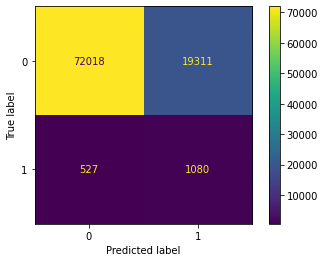

In [420]:
ConfusionMatrixDisplay(confusion_matrix(yval, ypred_val)).plot()

In [942]:
# updated weather cols to reflect accidents with multiple conditions (eg wind+rain)

rf = RandomForestClassifier(class_weight=class_weights)

params = {
    'n_estimators': [50, 100, 500, 1000],
    'max_depth': [5, 10, 20],
    'max_features': [3, 4, 6]
}


gs = GridSearchCV(rf, params, scoring='recall_macro', n_jobs=8, cv=3)
gs.fit(xtrain_transformed, ytrain)
print(gs.best_params_)

ypred_train = gs.predict(xtrain_transformed)
ypred_val = gs.predict(xval_transformed)

print('training scores')
print(classification_report(ytrain, ypred_train))

{'max_depth': 5, 'max_features': 6, 'n_estimators': 50}
training scores
              precision    recall  f1-score   support

           0       0.99      0.76      0.86    177490
           1       0.05      0.71      0.10      3321

    accuracy                           0.76    180811
   macro avg       0.52      0.73      0.48    180811
weighted avg       0.98      0.76      0.85    180811



In [415]:
print('validation scores')
print(classification_report(yval, ypred_val))

validation scores
              precision    recall  f1-score   support

           0       0.99      0.79      0.88     91329
           1       0.05      0.67      0.10      1607

    accuracy                           0.79     92936
   macro avg       0.52      0.73      0.49     92936
weighted avg       0.98      0.79      0.87     92936



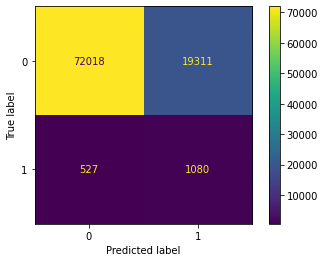

In [420]:
ConfusionMatrixDisplay(confusion_matrix(yval, ypred_val)).plot()

In [1070]:
# combined dayofweek and time col into 1 categorical column

rf = RandomForestClassifier(class_weight=class_weights)

params = {
    'n_estimators': [50, 100, 500, 1000],
    'max_depth': [5, 10, 20],
    'max_features': [3, 4, 6]
}


gs = GridSearchCV(rf, params, scoring='recall_macro', n_jobs=8, cv=3)
gs.fit(xtrain_transformed, ytrain)
print(gs.best_params_)

ypred_train = gs.predict(xtrain_transformed)
ypred_val = gs.predict(xval_transformed)

print('training scores')
print(classification_report(ytrain, ypred_train))

{'max_depth': 10, 'max_features': 6, 'n_estimators': 500}
training scores
              precision    recall  f1-score   support

           0       0.99      0.80      0.88    177490
           1       0.06      0.74      0.12      3321

    accuracy                           0.80    180811
   macro avg       0.53      0.77      0.50    180811
weighted avg       0.98      0.80      0.87    180811



In [1072]:
print('validation scores')
print(classification_report(yval, ypred_val))

validation scores
              precision    recall  f1-score   support

           0       0.99      0.80      0.88     76067
           1       0.06      0.69      0.11      1424

    accuracy                           0.79     77491
   macro avg       0.53      0.74      0.50     77491
weighted avg       0.98      0.79      0.87     77491



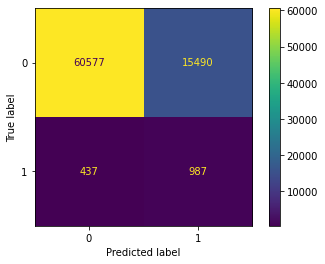

In [1073]:
ConfusionMatrixDisplay(confusion_matrix(yval, ypred_val)).plot()

In [1074]:
ypred_test = gs.predict(xtest_transformed)

print('test scores')
print(classification_report(ytest, ypred_test))

test scores
              precision    recall  f1-score   support

           0       0.99      0.80      0.88    108669
           1       0.06      0.68      0.11      2033

    accuracy                           0.80    110702
   macro avg       0.53      0.74      0.50    110702
weighted avg       0.98      0.80      0.87    110702



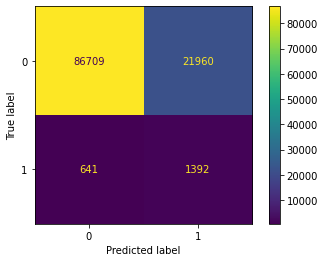

In [1075]:
ConfusionMatrixDisplay(confusion_matrix(ytest, ypred_test)).plot()